In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def heat_equation_2D_fourier(Lx, Ly, Nx, Ny, Tmax, Nt, initial_condition):
    """
    Solve the 2D heat equation using Fourier series.

    Parameters:
        Lx, Ly (float): Dimensions of the 2D plate.
        Nx, Ny (int): Number of Fourier modes in each dimension.
        Tmax (float): Maximum time for simulation.
        Nt (int): Number of time steps.
        initial_condition (function): Function f(x, y) specifying the initial temperature.

    Returns:
        x (ndarray): x-coordinates.
        y (ndarray): y-coordinates.
        u (ndarray): Temperature distribution at each time step.
    """
    # Spatial domain
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)

    # Time domain
    dt = Tmax / Nt
    t = np.linspace(0, Tmax, Nt)

    # Initialize temperature
    u0 = initial_condition(X, Y)

    # Fourier coefficients of initial condition
    def fourier_coefficients(u0, Lx, Ly, Nx, Ny):
        coeff = np.zeros((Nx, Ny))
        for m in range(Nx):
            for n in range(Ny):
                integrand = u0 * np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly)
                coeff[m, n] = (4 / (Lx * Ly)) * np.trapz(np.trapz(integrand, x), y)
        return coeff

    coeff = fourier_coefficients(u0, Lx, Ly, Nx, Ny)

    # Initialize solution array
    u = np.zeros((Nt, Ny, Nx))
    u[0, :, :] = u0

    # Solve the heat equation in Fourier space
    for k, time in enumerate(t):
        if k == 0:
            continue
        solution = np.zeros_like(u0)
        for m in range(1, Nx):
            for n in range(1, Ny):
                decay = np.exp(-((m * np.pi / Lx) ** 2 + (n * np.pi / Ly) ** 2) * time)
                solution += (
                    coeff[m, n]
                    * np.sin(m * np.pi * X / Lx)
                    * np.sin(n * np.pi * Y / Ly)
                    * decay
                )
        u[k, :, :] = solution

    return x, y, u

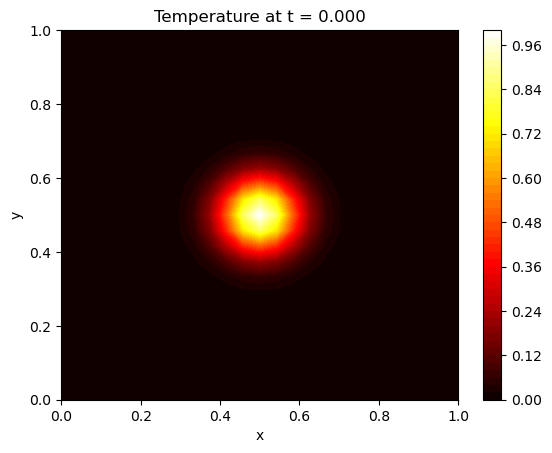

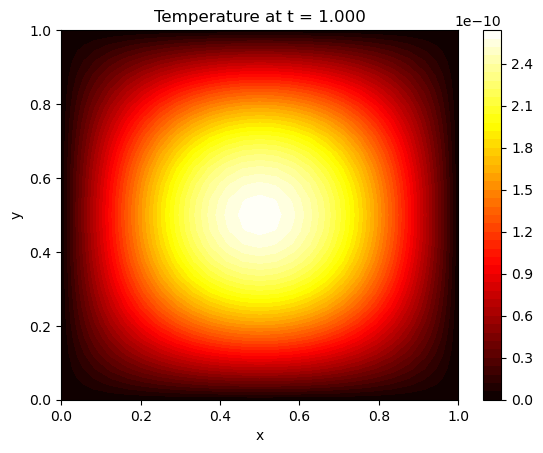

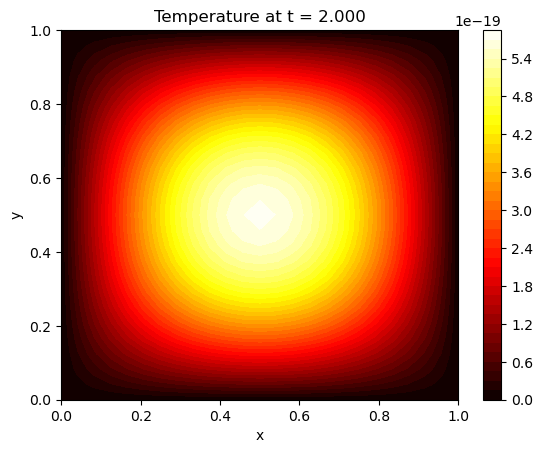

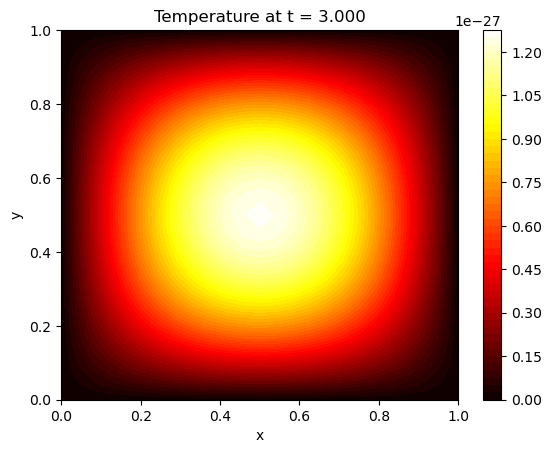

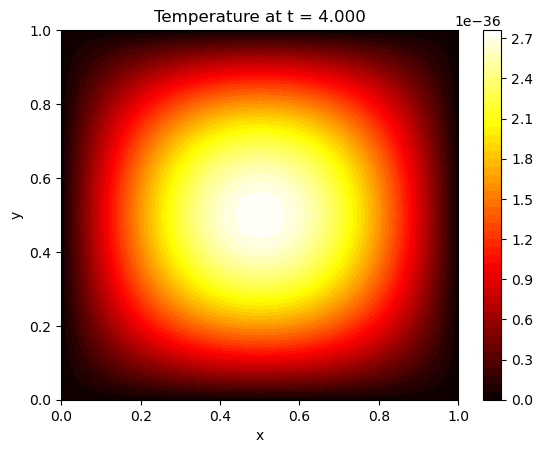

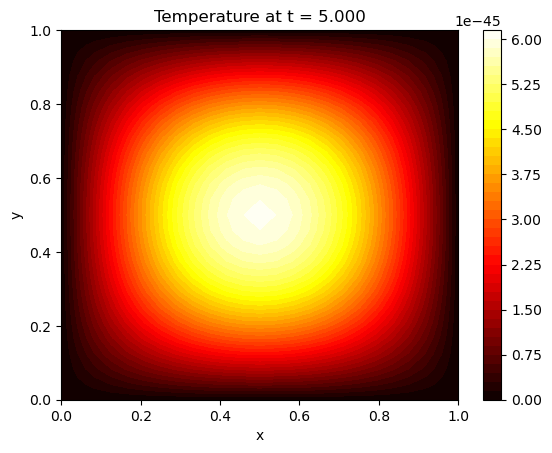

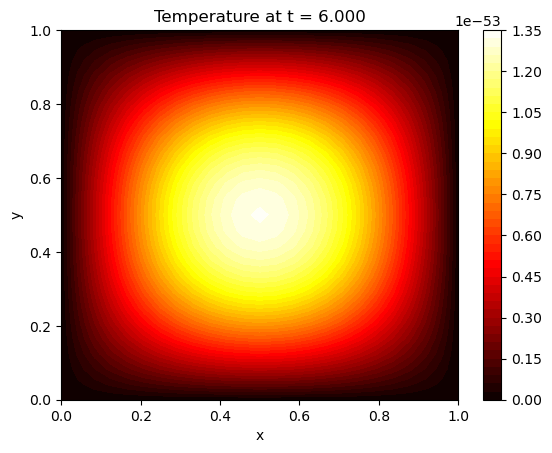

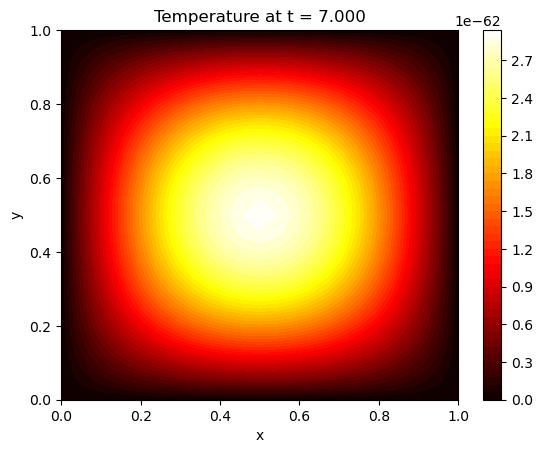

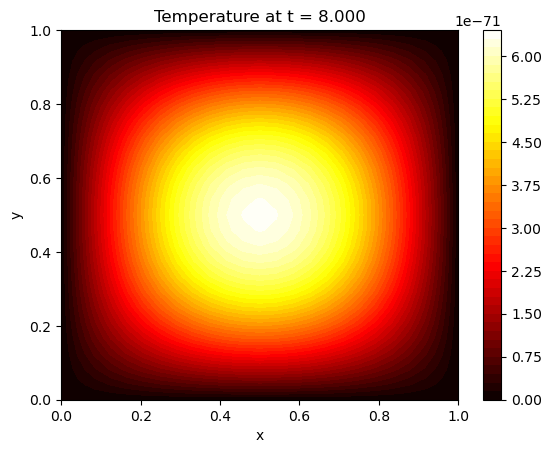

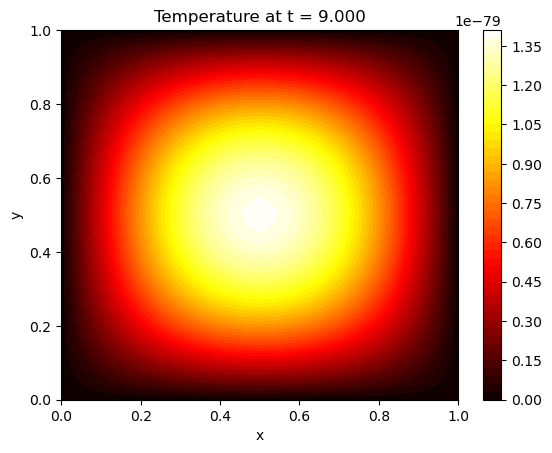

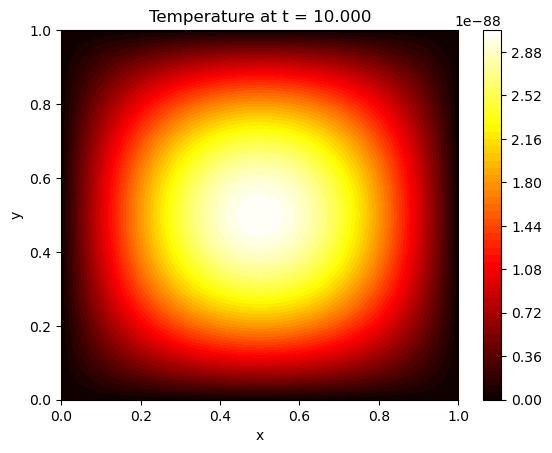

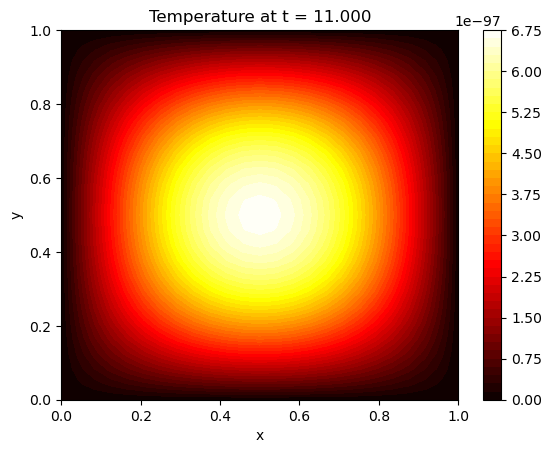

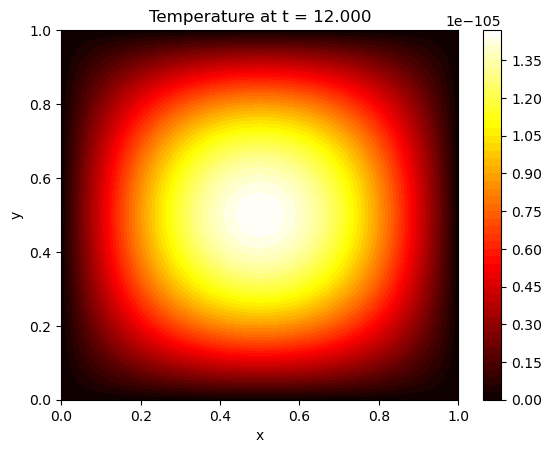

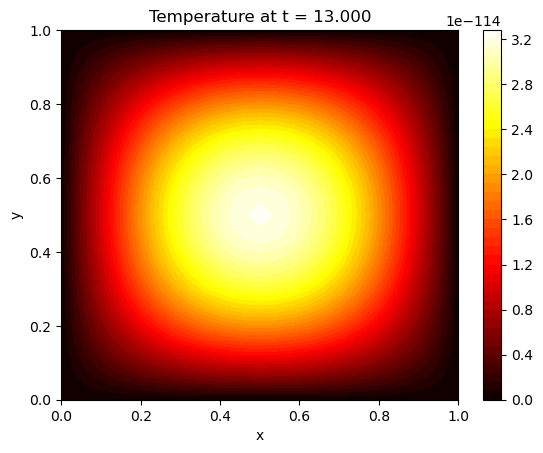

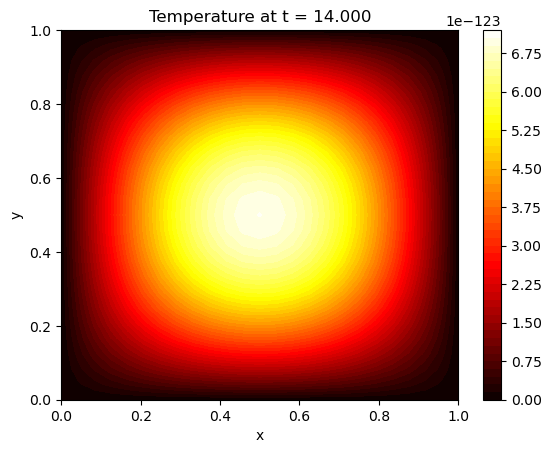

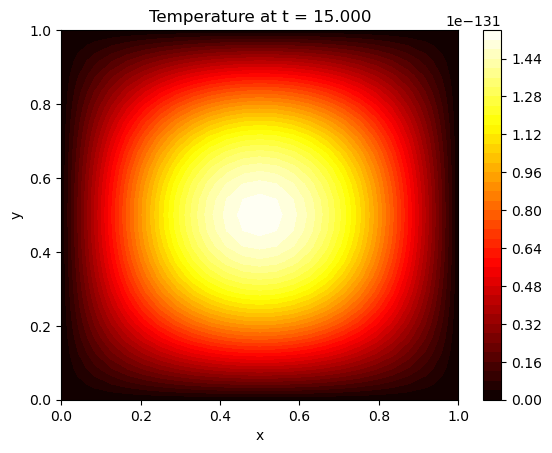

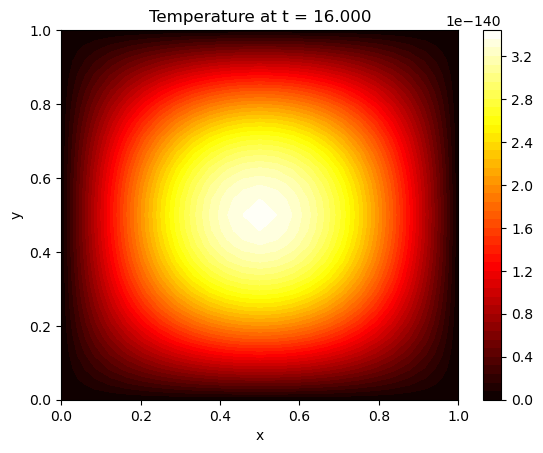

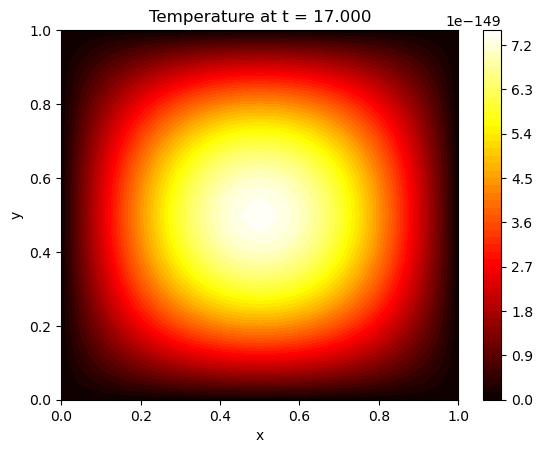

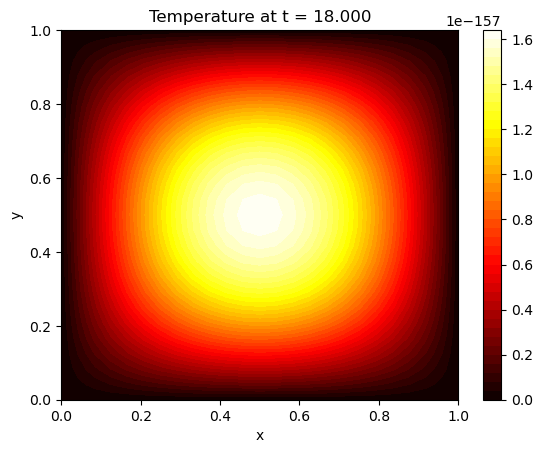

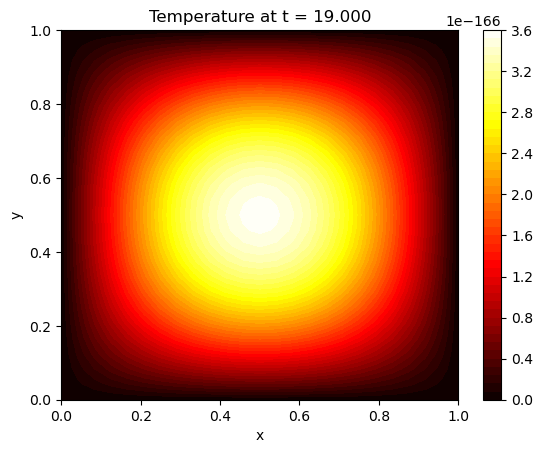

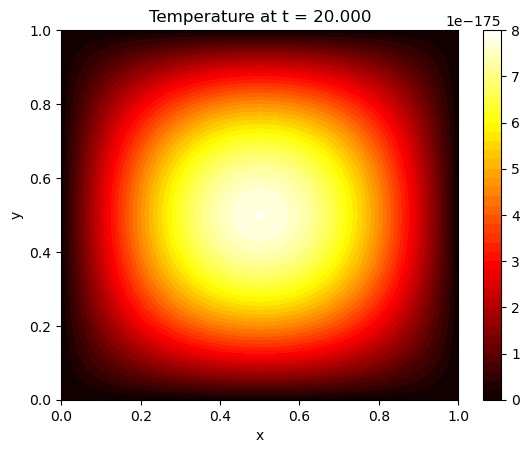

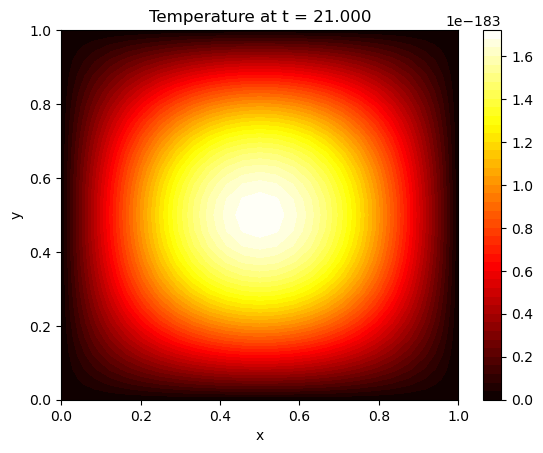

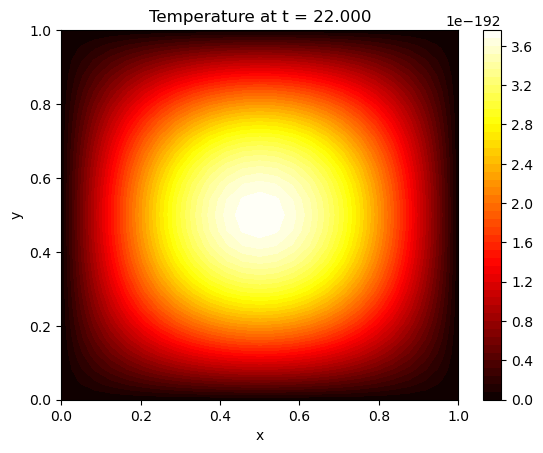

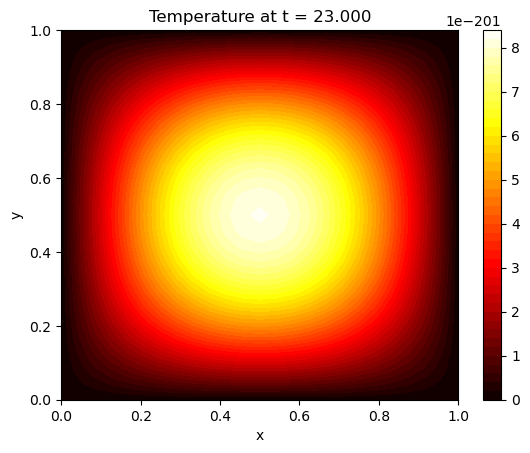

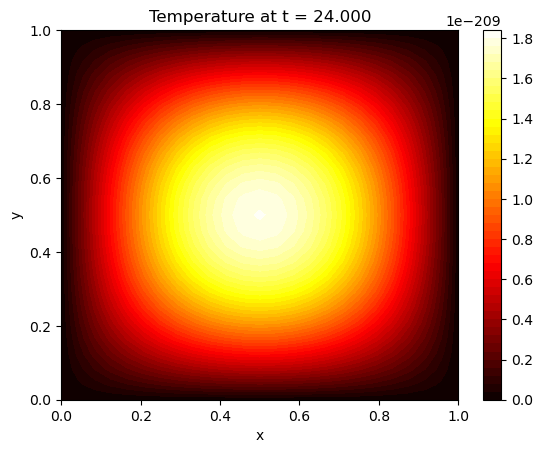

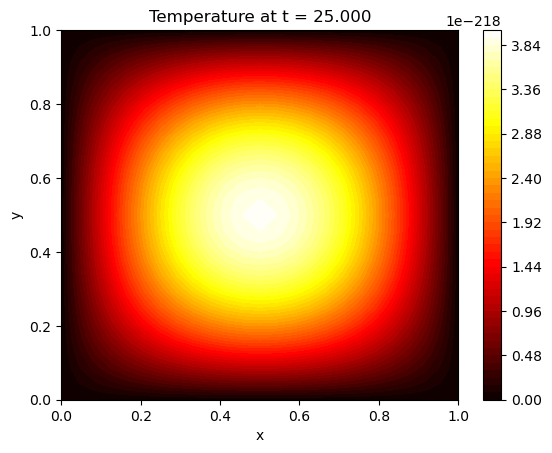

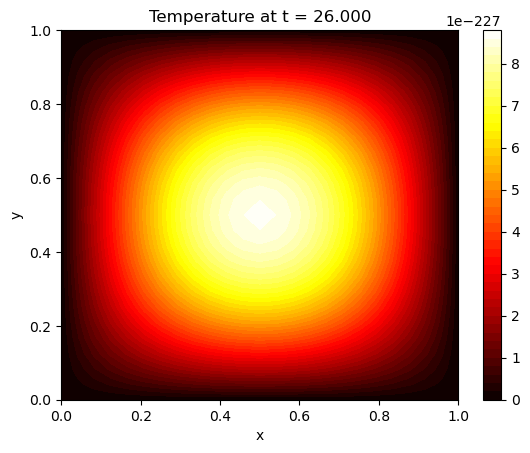

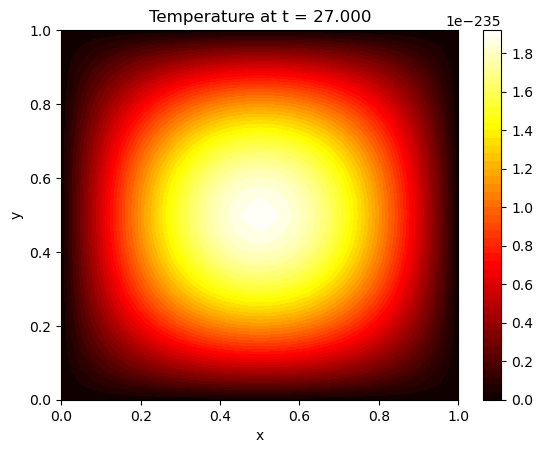

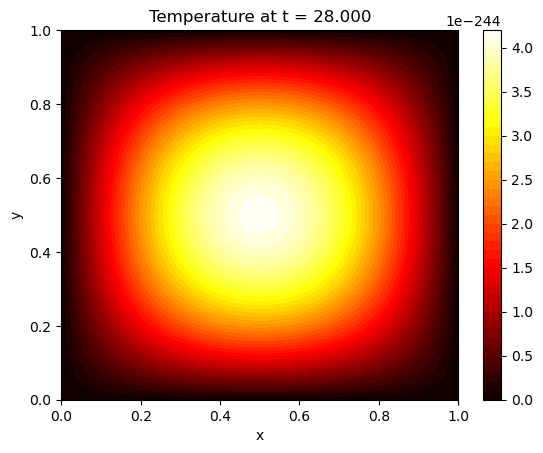

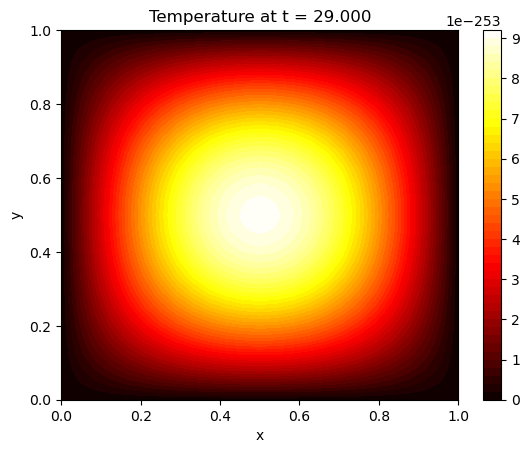

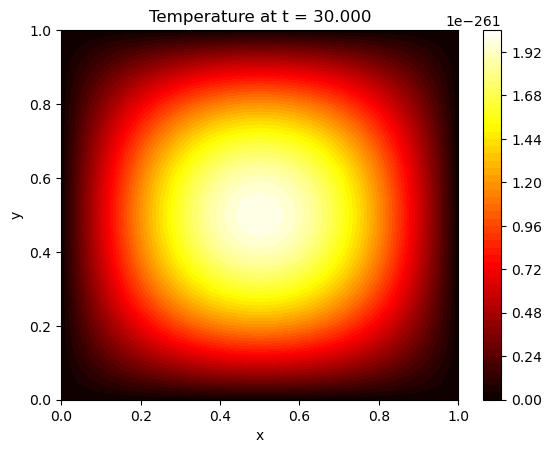

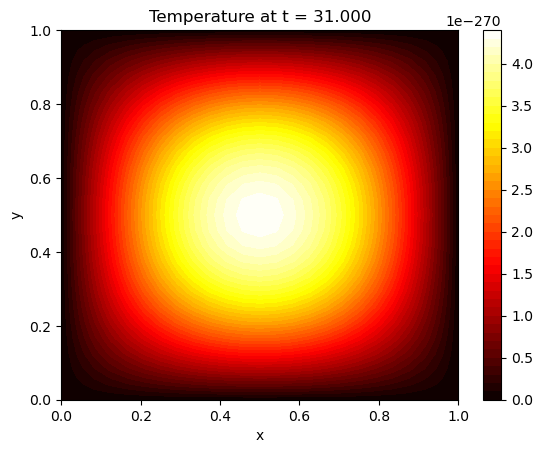

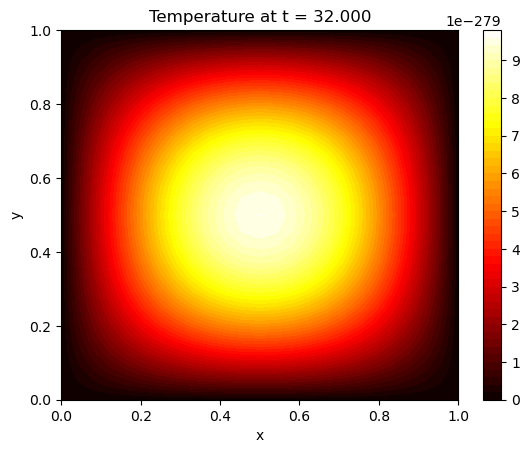

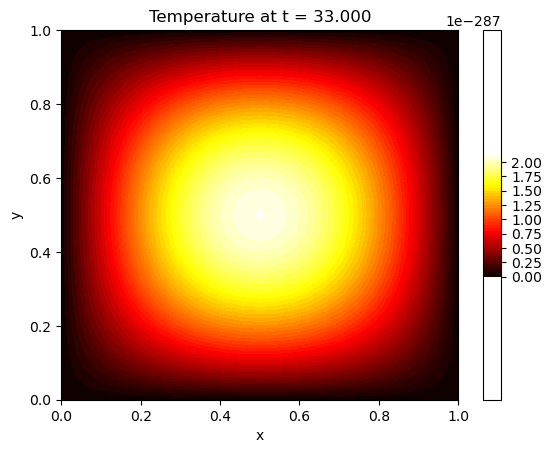

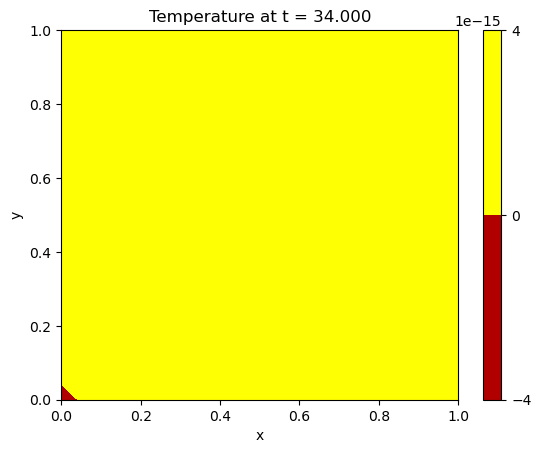

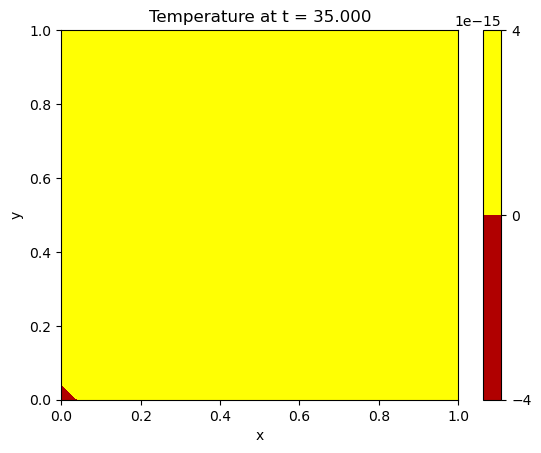

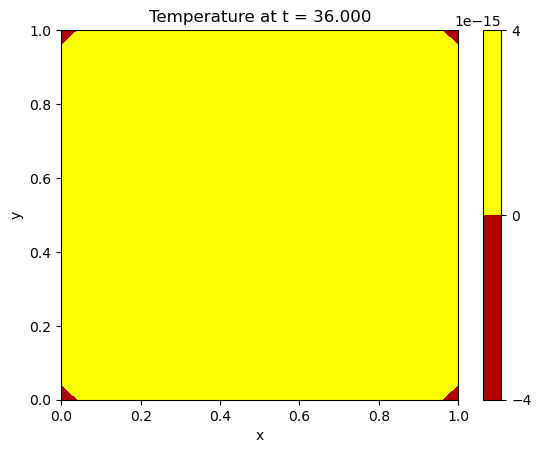

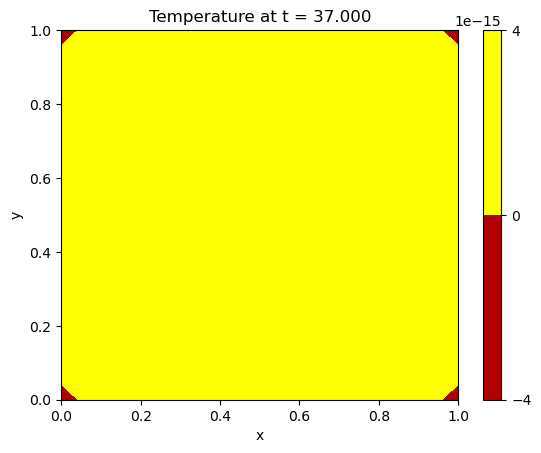

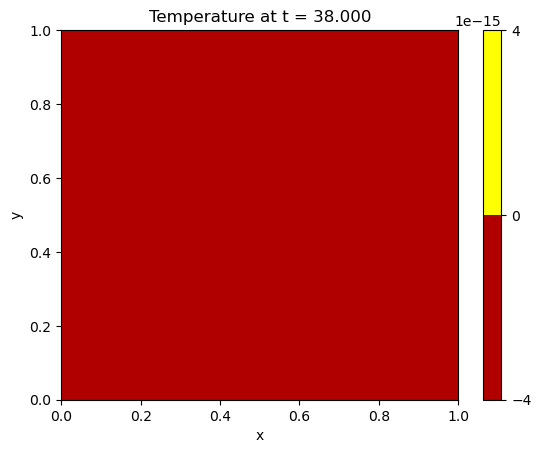

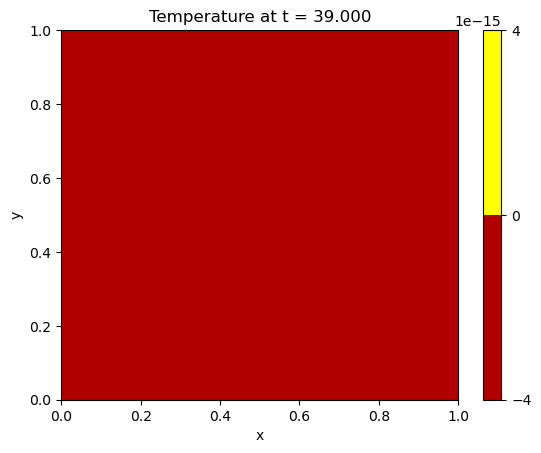

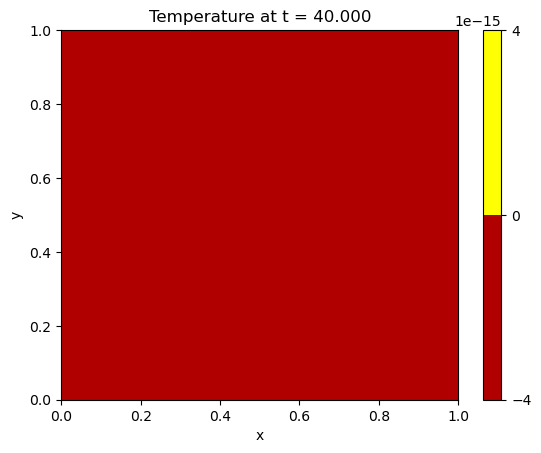

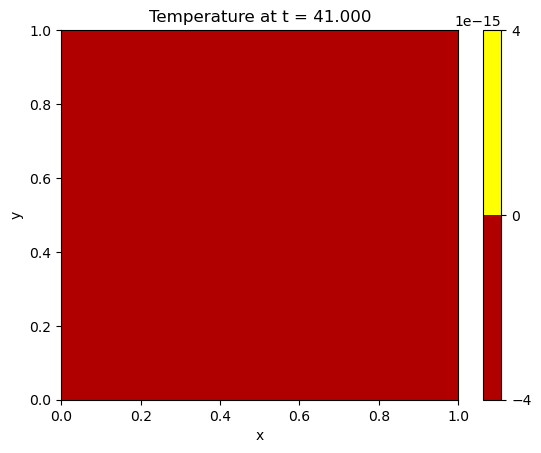

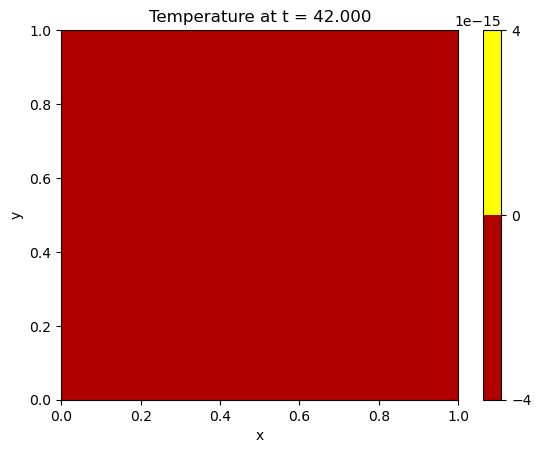

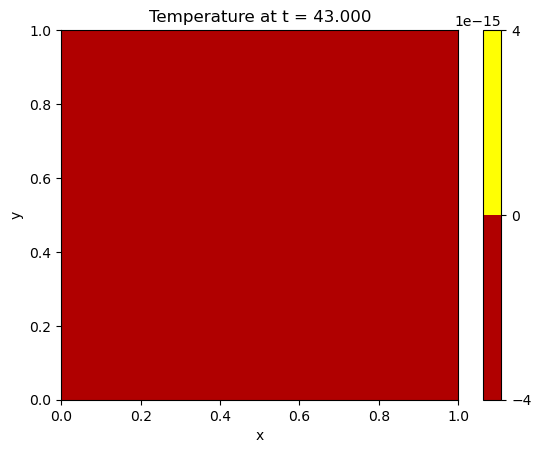

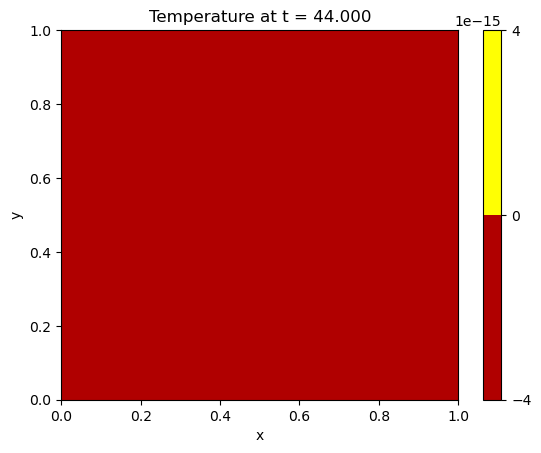

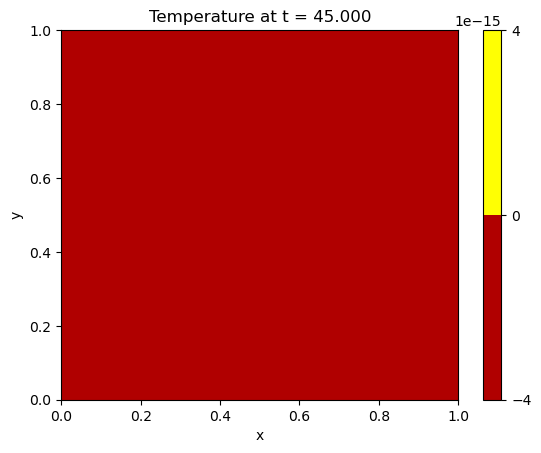

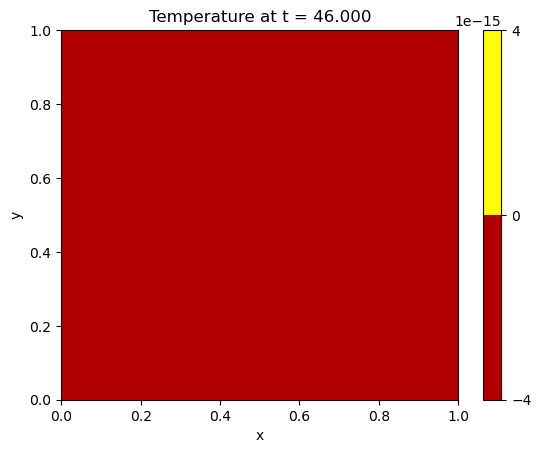

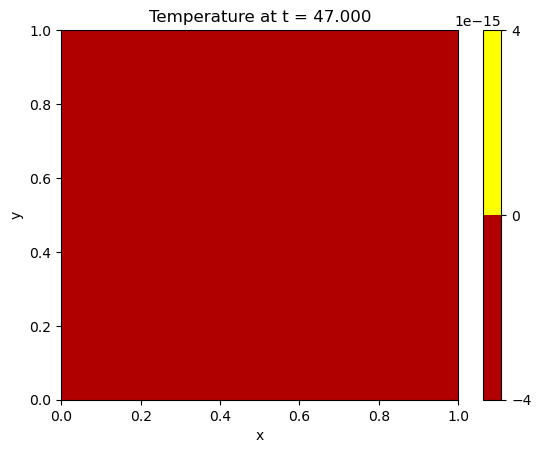

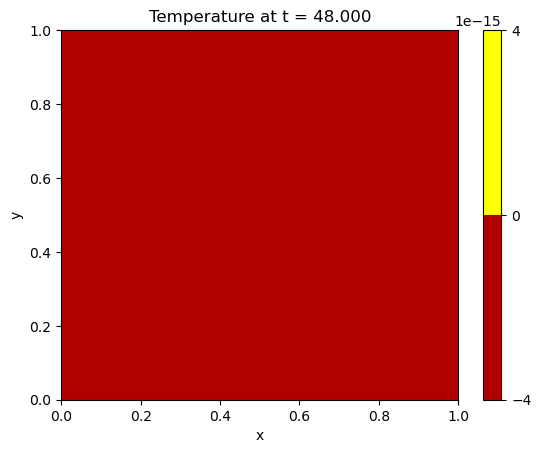

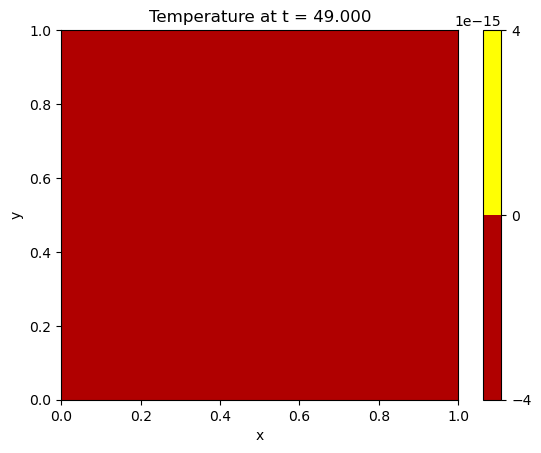

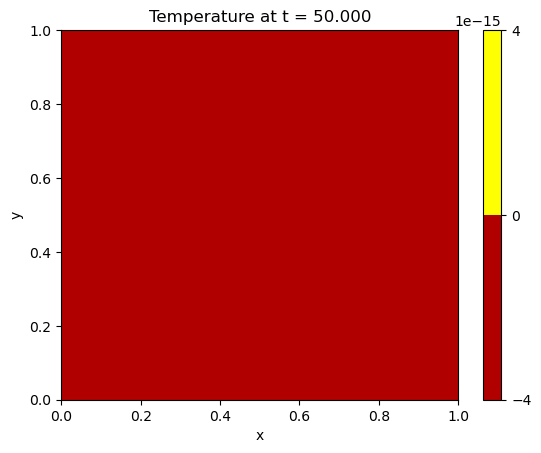

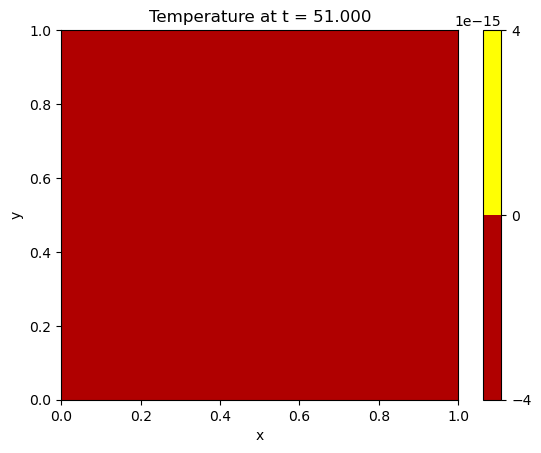

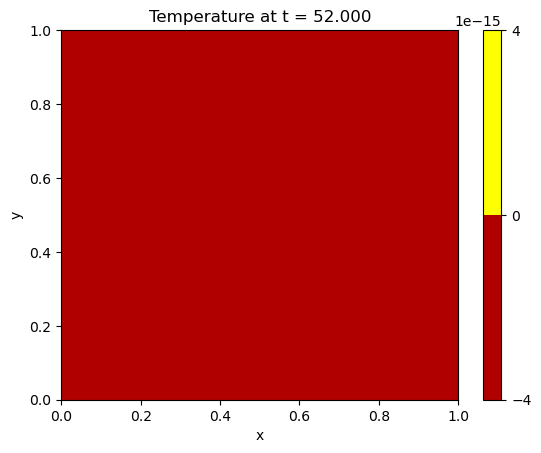

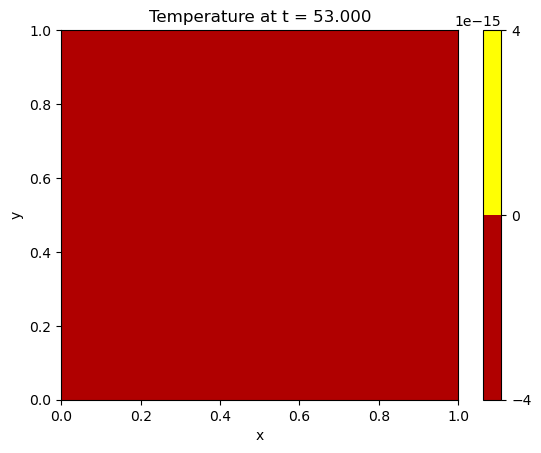

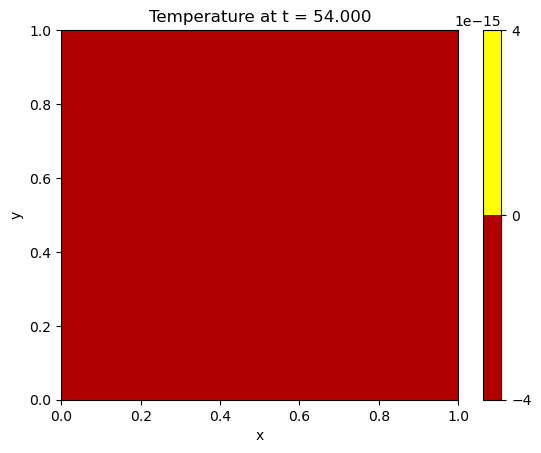

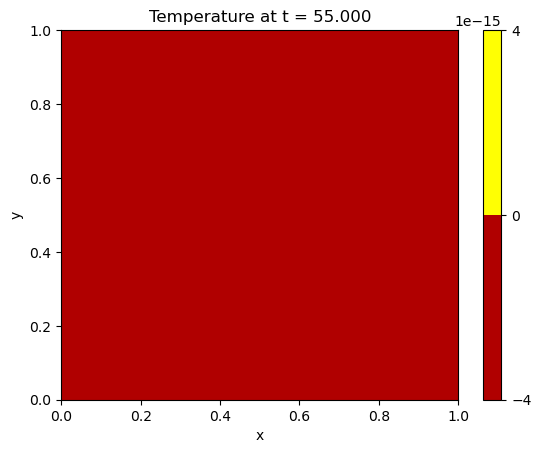

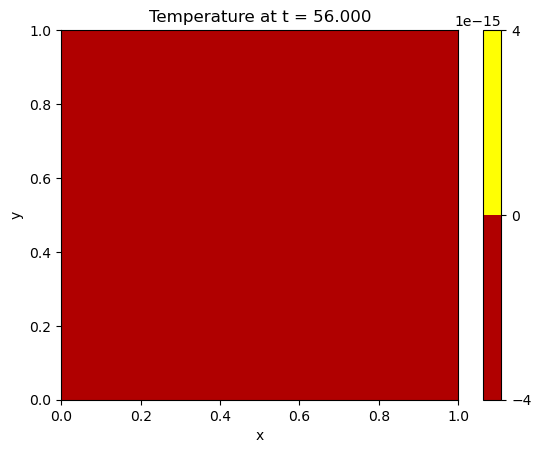

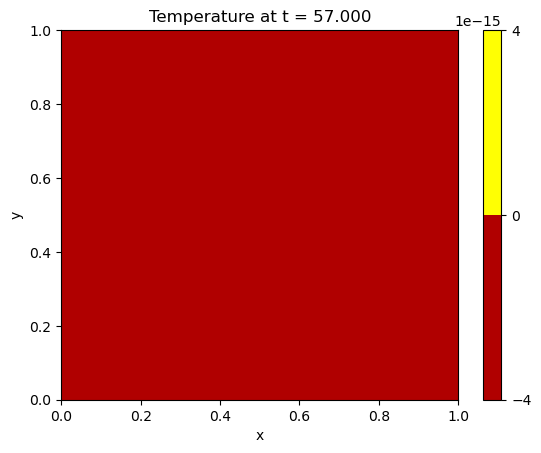

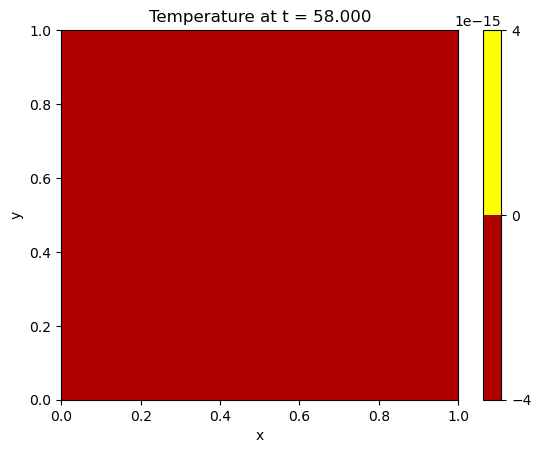

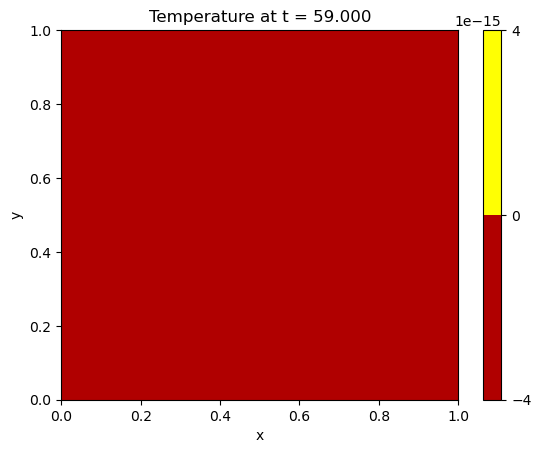

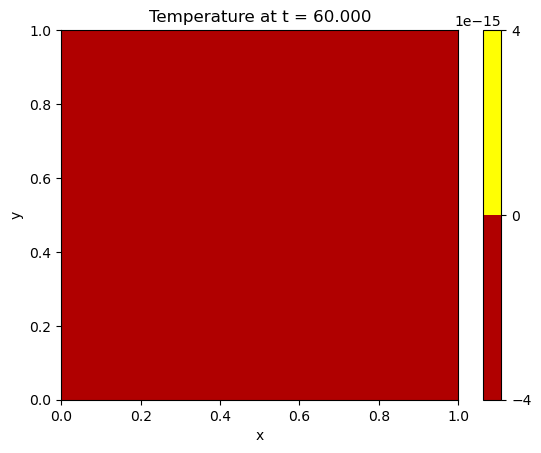

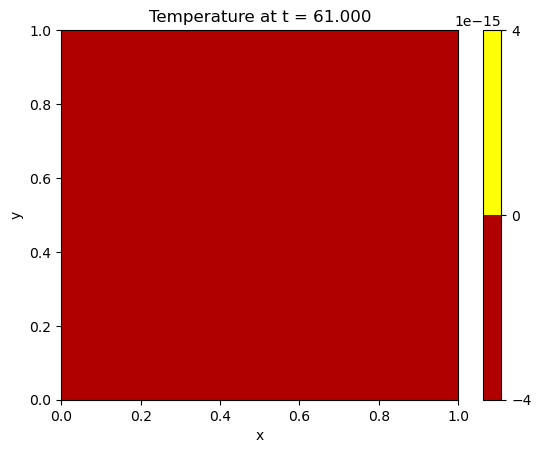

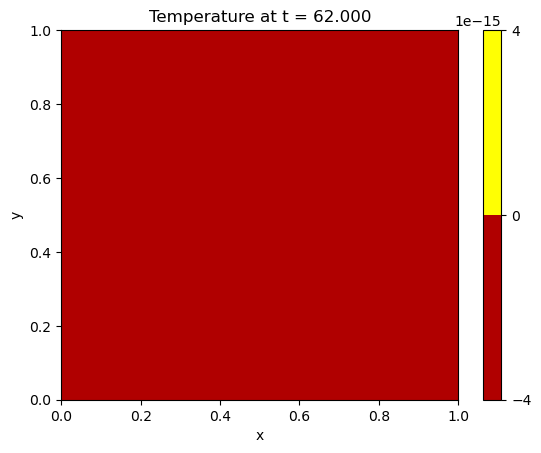

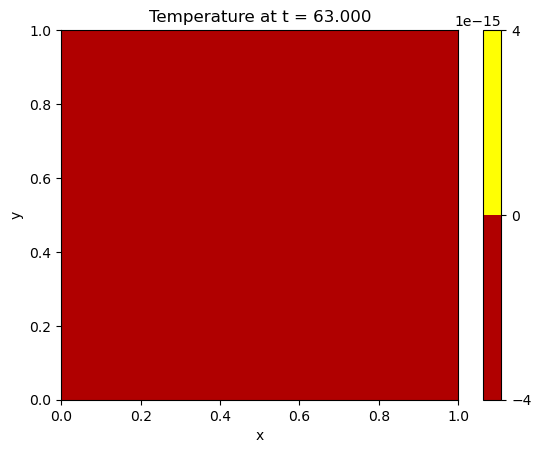

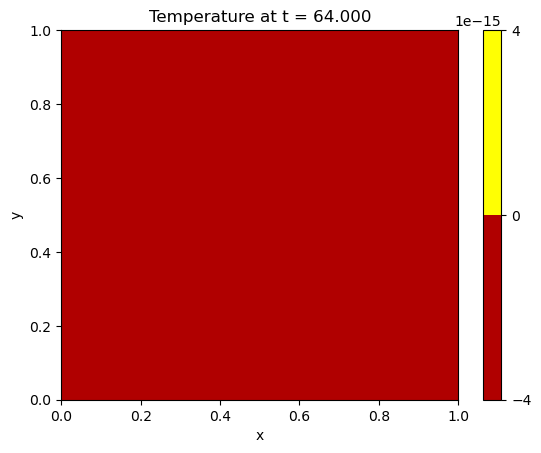

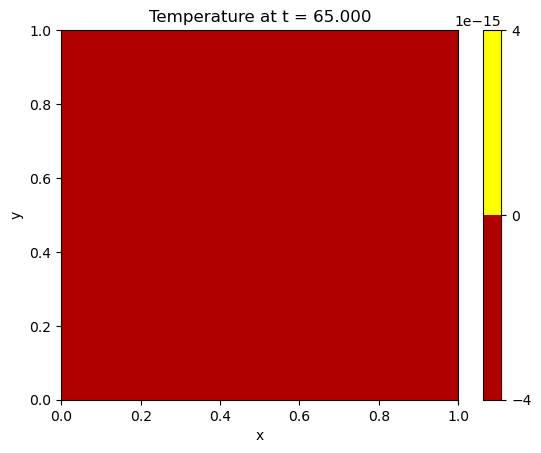

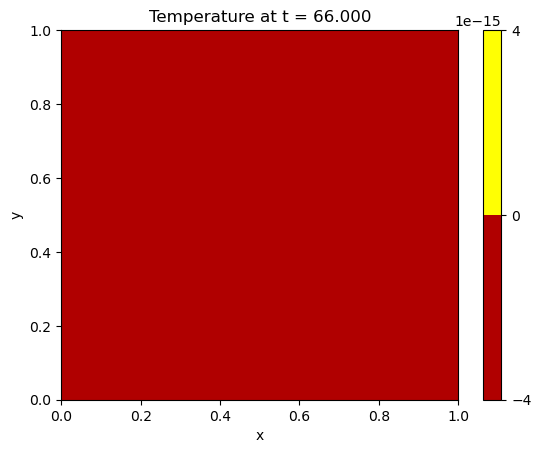

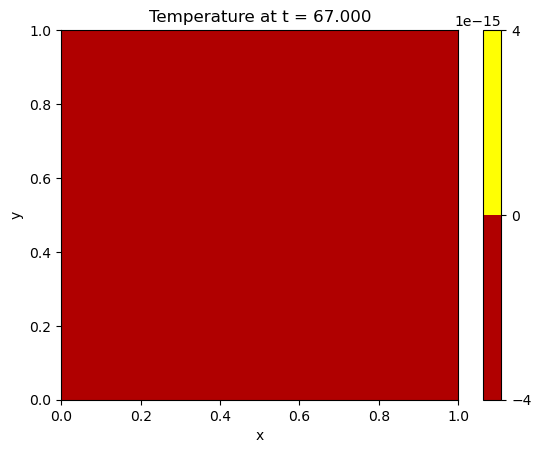

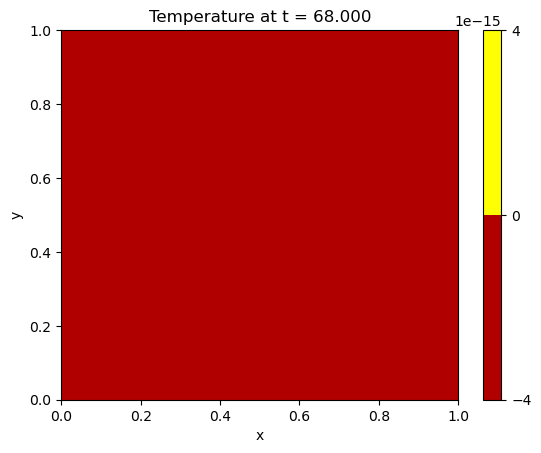

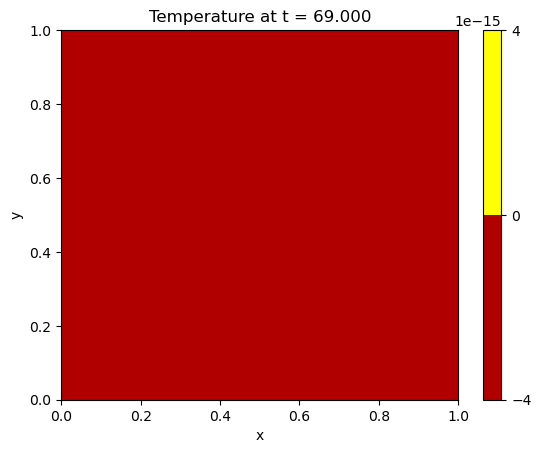

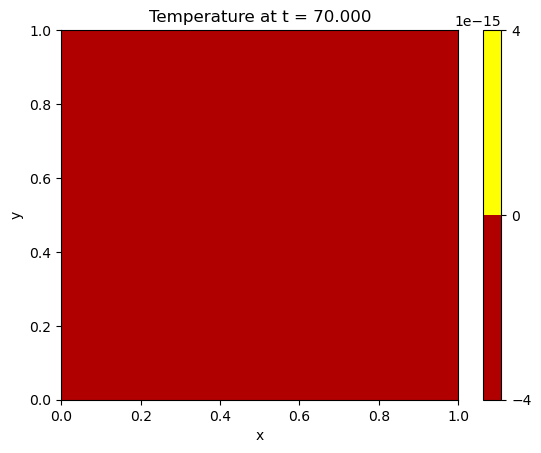

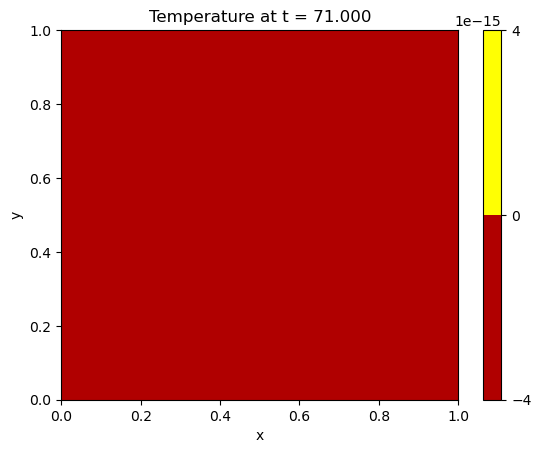

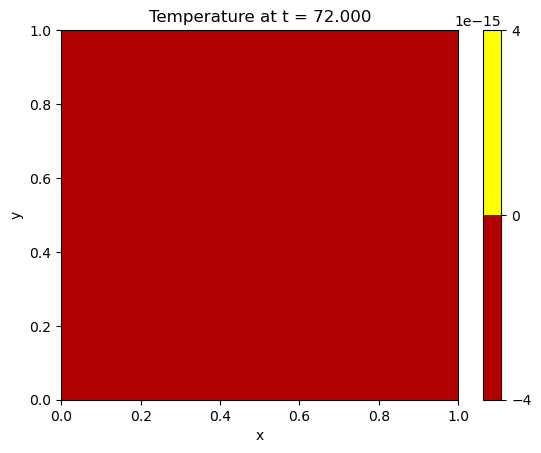

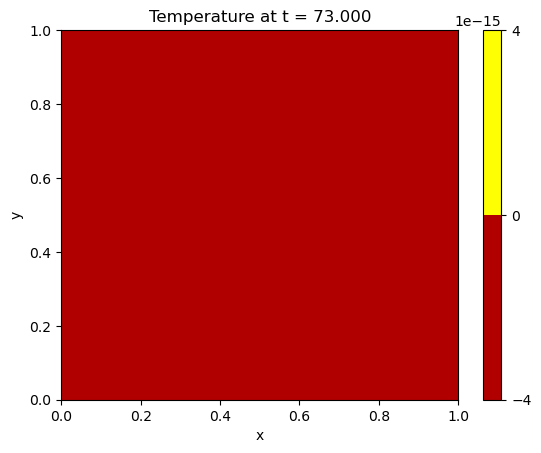

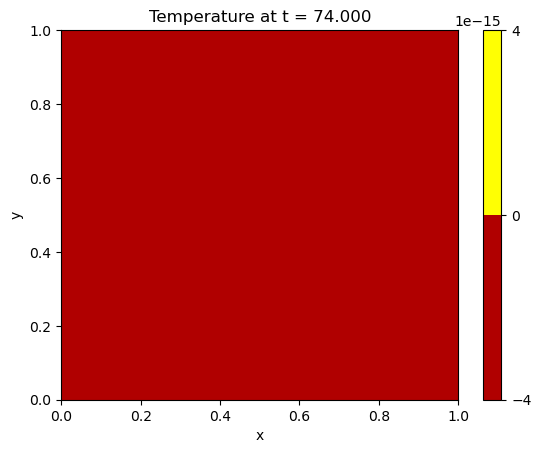

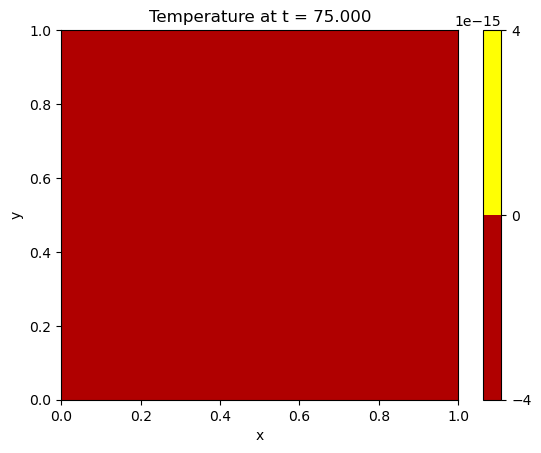

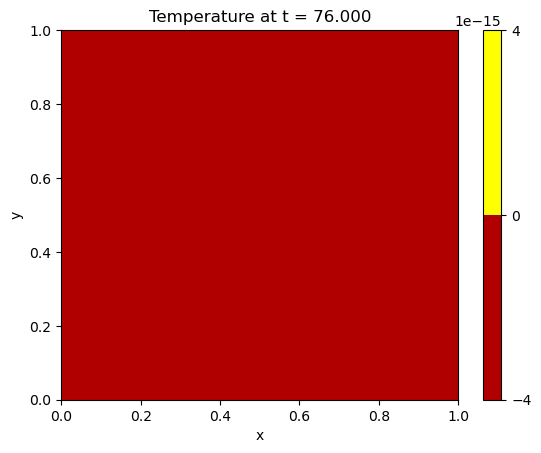

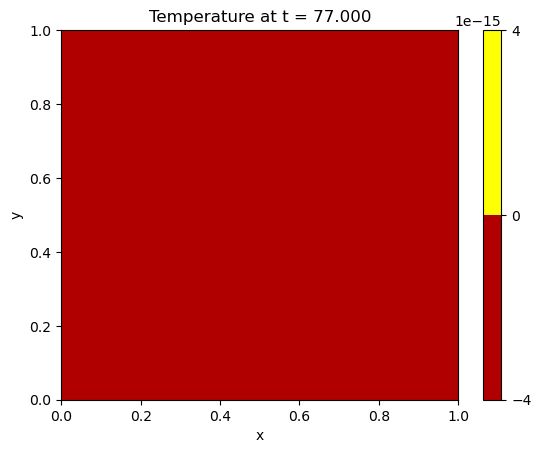

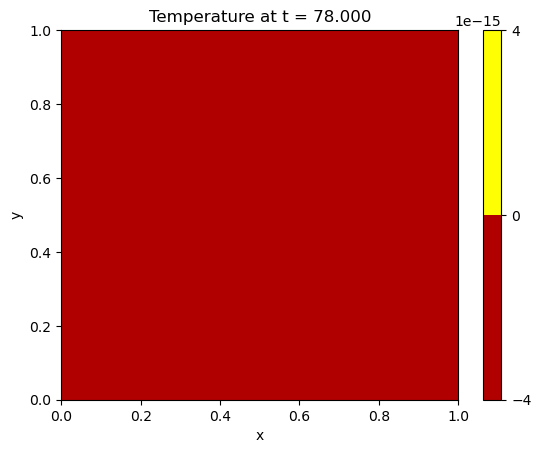

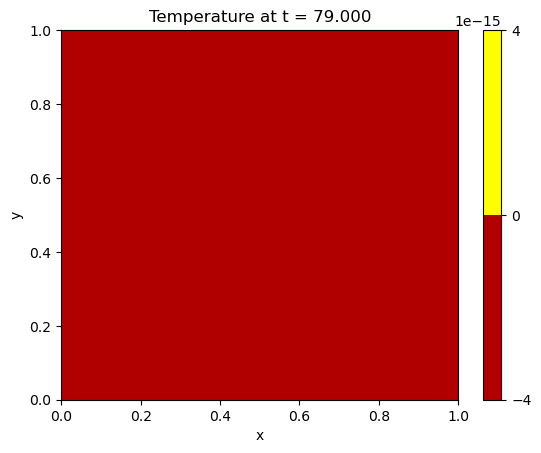

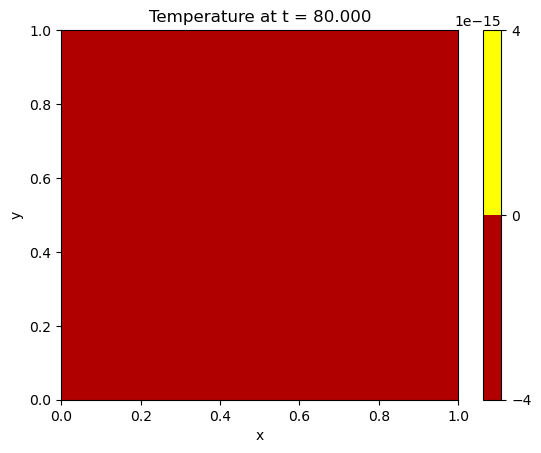

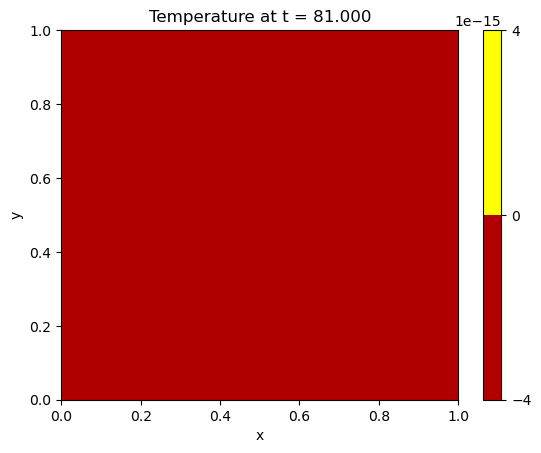

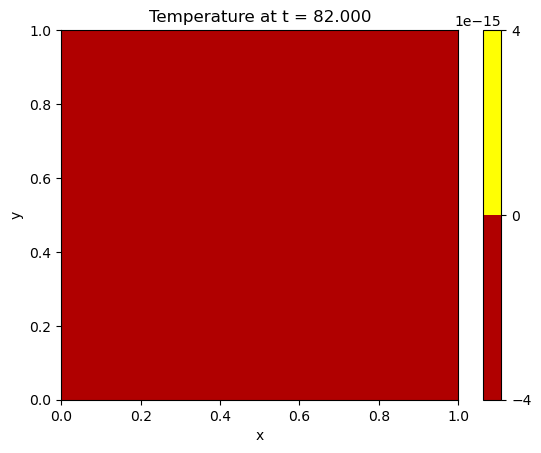

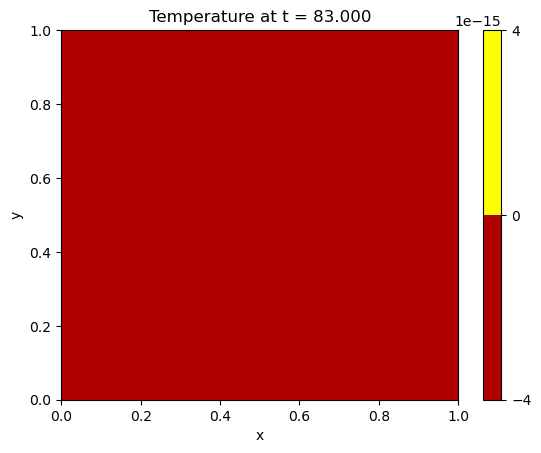

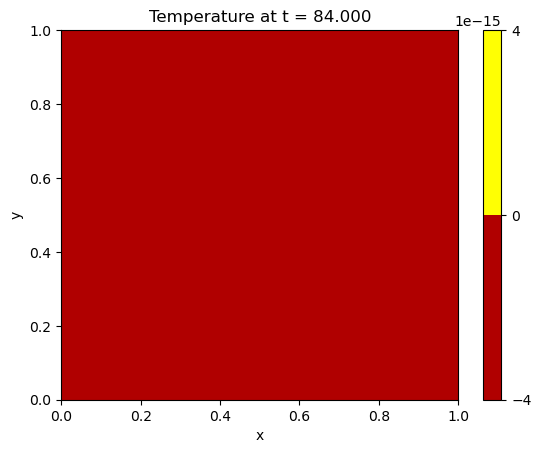

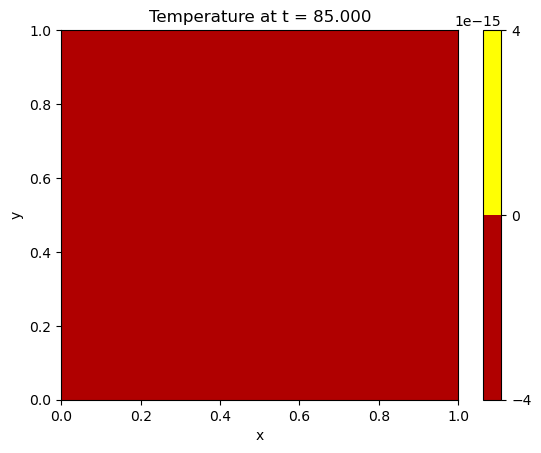

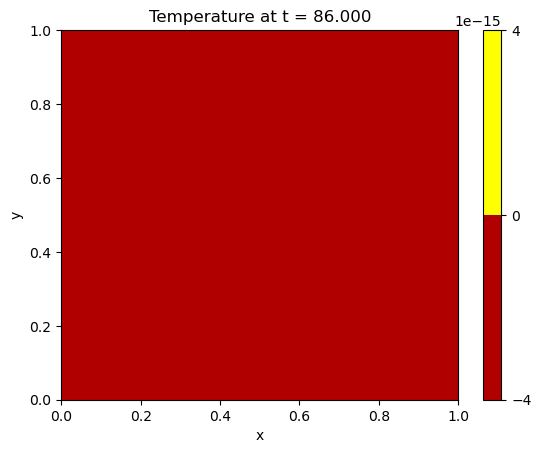

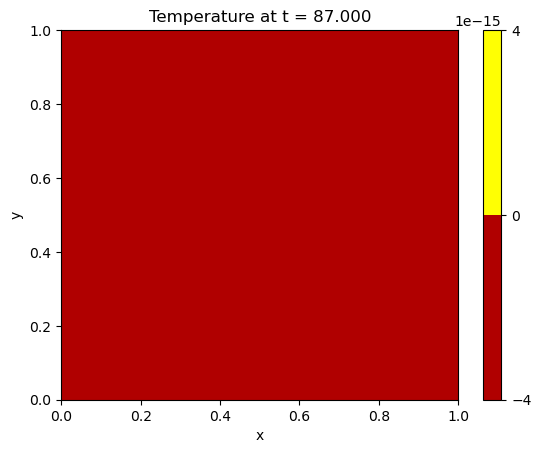

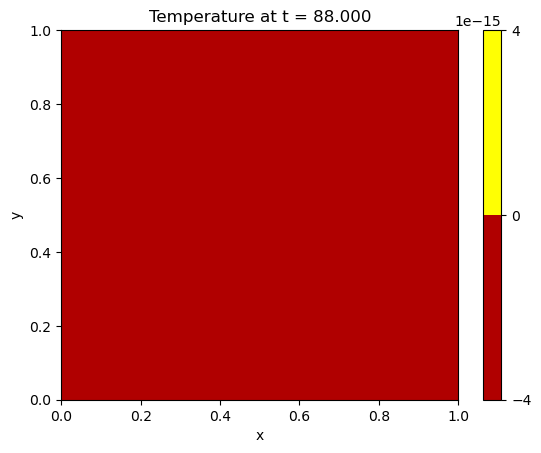

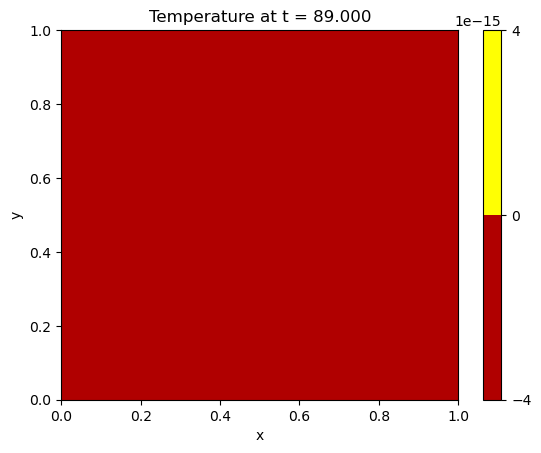

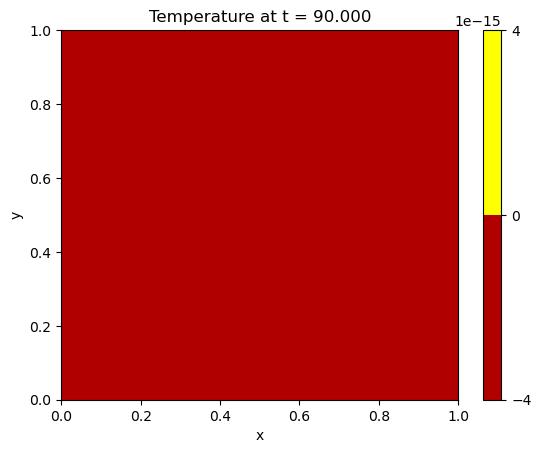

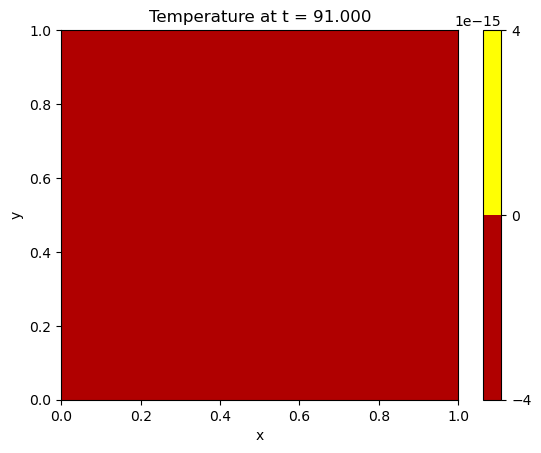

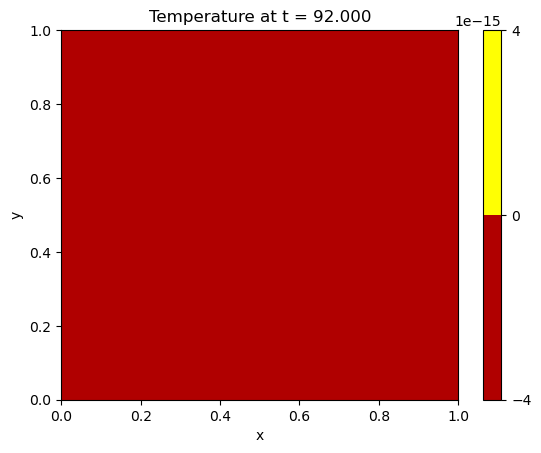

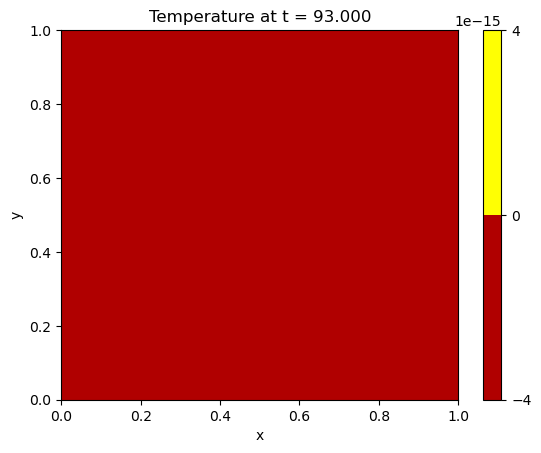

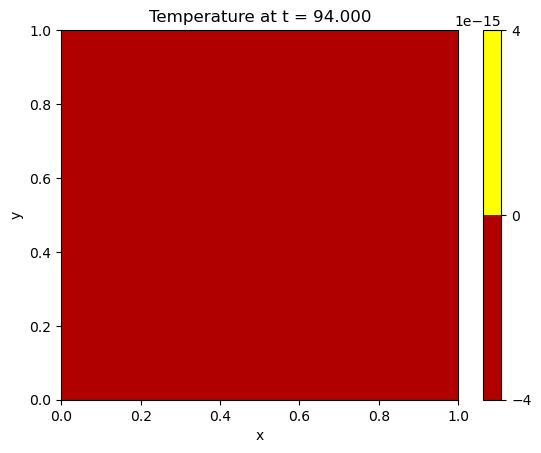

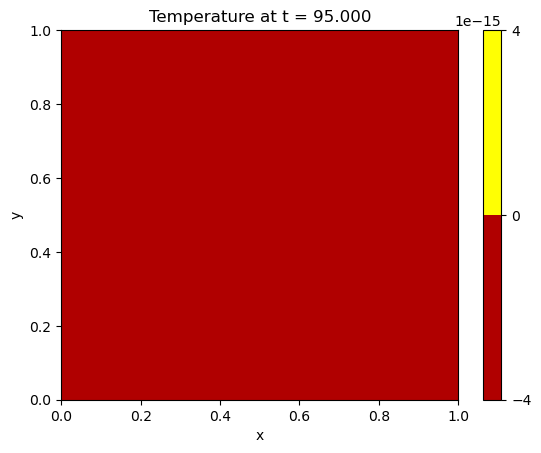

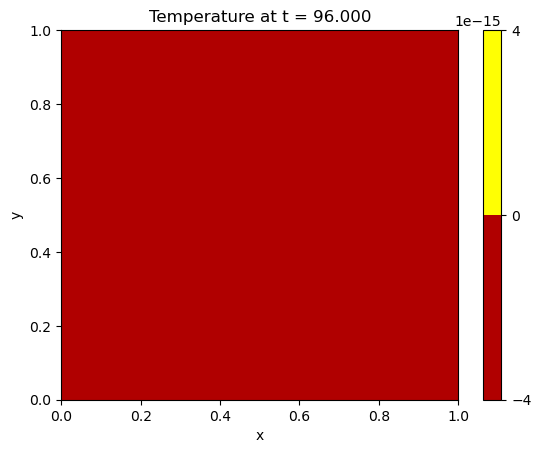

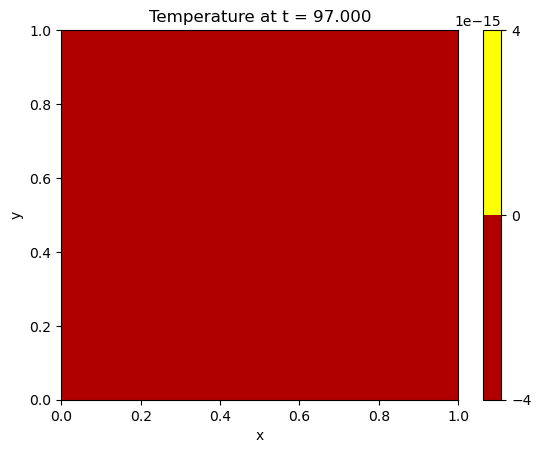

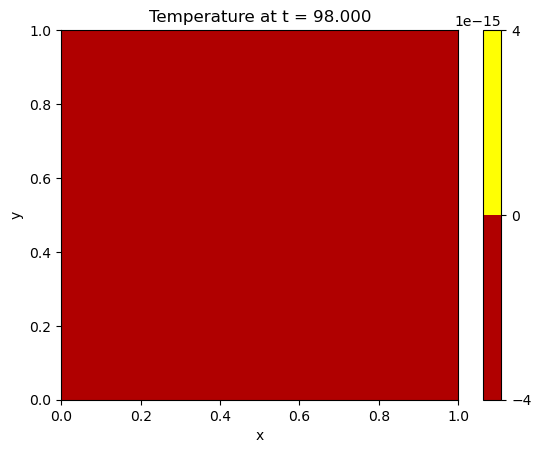

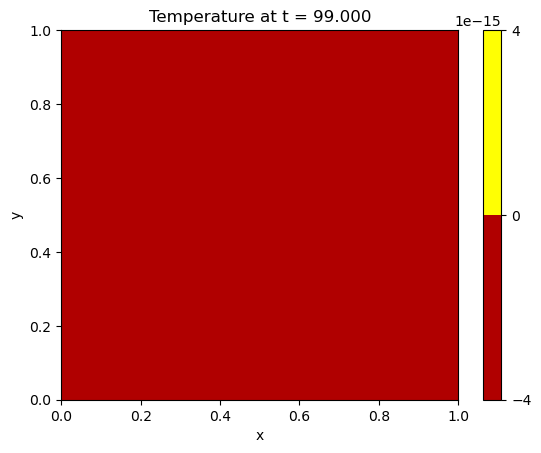

In [12]:
# Define parameters
Lx, Ly = 1.0, 1.0  # Plate dimensions
Nx, Ny = 25, 25  # Number of Fourier modes
Tmax = 100  # Maximum simulation time
Nt = 100  # Number of time steps

# Initial condition: Gaussian distribution
def initial_condition(x, y):
    return np.exp(-((x - Lx / 2) ** 2 + (y - Ly / 2) ** 2) / 0.01)

# Solve the heat equation
x, y, u = heat_equation_2D_fourier(Lx, Ly, Nx, Ny, Tmax, Nt, initial_condition)

# Visualize the result
X, Y = np.meshgrid(x, y)
for k in range(0, Nt):
    plt.figure()
    plt.contourf(X, Y, u[k, :, :], levels=50, cmap="hot")
    plt.colorbar()
    plt.title(f"Temperature at t = {k * Tmax / Nt:.3f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def heat_equation_2D_fourier_irregular(Lx, Ly, Nx, Ny, Tmax, Nt, initial_condition, mask):
    """
    Solve the 2D heat equation on an irregularly shaped plate using Fourier series.

    Parameters:
        Lx, Ly (float): Dimensions of the 2D grid.
        Nx, Ny (int): Number of grid points in each dimension.
        Tmax (float): Maximum time for simulation.
        Nt (int): Number of time steps.
        initial_condition (ndarray): Initial temperature distribution.
        mask (ndarray): Boolean array defining the plate shape (True for inside the plate).

    Returns:
        x (ndarray): x-coordinates.
        y (ndarray): y-coordinates.
        u (ndarray): Temperature distribution at each time step.
    """
    # Spatial domain
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)

    # Time domain
    dt = Tmax / Nt
    t = np.linspace(0, Tmax, Nt)

    # Fourier coefficients of initial condition
    def fourier_coefficients(u0, Lx, Ly, Nx, Ny, mask):
        coeff = np.zeros((Nx, Ny))
        for m in range(Nx):
            for n in range(Ny):
                if m == 0 or n == 0:
                    continue
                integrand = (
                    u0 * mask * np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly)
                )
                coeff[m, n] = (4 / (Lx * Ly)) * np.trapz(np.trapz(integrand, x), y)
        return coeff

    coeff = fourier_coefficients(initial_condition, Lx, Ly, Nx, Ny, mask)

    # Initialize solution array
    u = np.zeros((Nt, Ny, Nx))
    u[0, :, :] = initial_condition

    # Solve the heat equation in Fourier space
    for k, time in enumerate(t):
        if k == 0:
            continue
        solution = np.zeros_like(initial_condition)
        for m in range(1, Nx):
            for n in range(1, Ny):
                if coeff[m, n] == 0:
                    continue
                decay = np.exp(-((m * np.pi / Lx) ** 2 + (n * np.pi / Ly) ** 2) * time)
                solution += (
                    coeff[m, n]
                    * np.sin(m * np.pi * X / Lx)
                    * np.sin(n * np.pi * Y / Ly)
                    * decay
                )
        # Apply mask to enforce the irregular shape
        if solution.shape != mask.shape:
            raise ValueError("Shape mismatch: solution and mask must have the same shape")
        solution *= mask  # Keep values only inside the mask  # Zero temperature outside the plate
        u[k, :, :] = solution

    return x, y, u

# Define parameters
Lx, Ly = 1.0, 1.0  # Grid dimensions
Nx, Ny = 100, 100  # Grid resolution
Tmax = 0.1  # Maximum simulation time
Nt = 10  # Number of time steps

# Create a random shape (plate mask)
def generate_random_mask(Nx, Ny):
    np.random.seed(42)  # For reproducibility
    mask = np.random.rand(Ny, Nx) > 0.5
    mask = gaussian_filter(mask.astype(float), sigma=5) > 0.5
    return mask

mask = generate_random_mask(Nx, Ny)



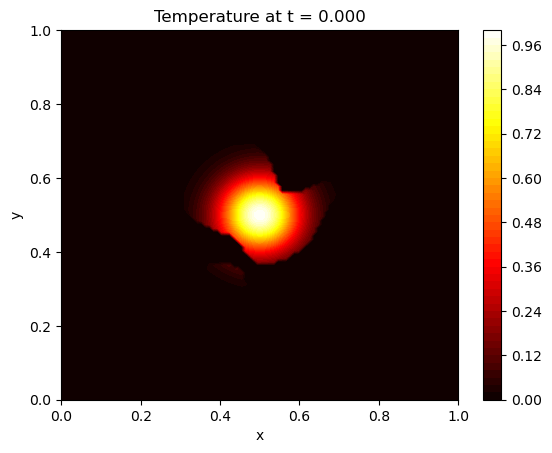

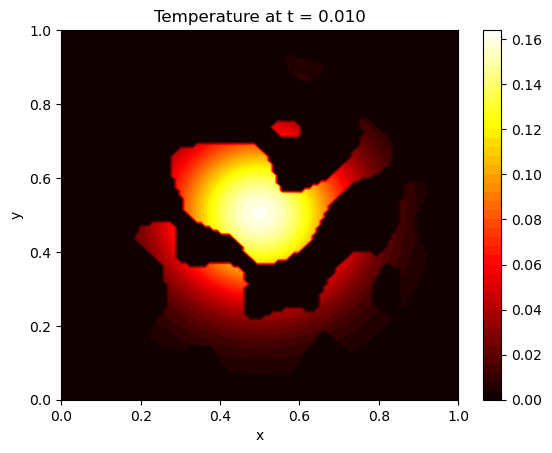

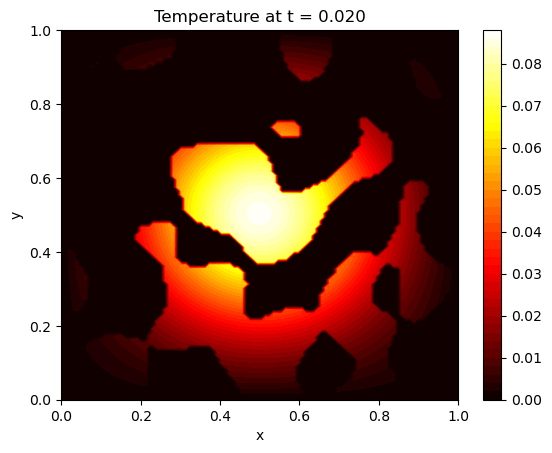

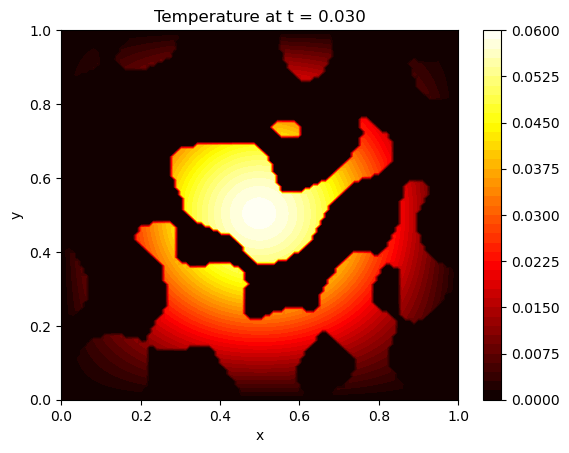

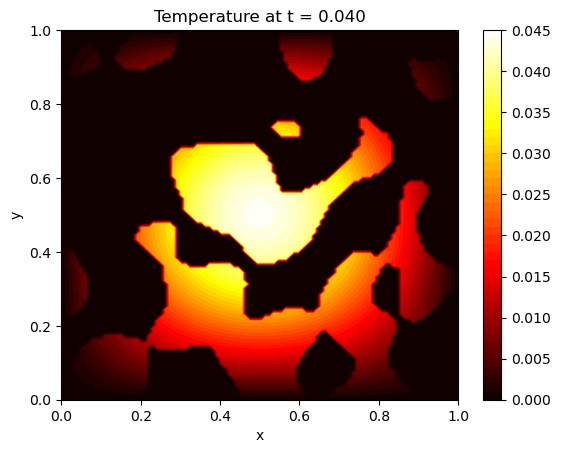

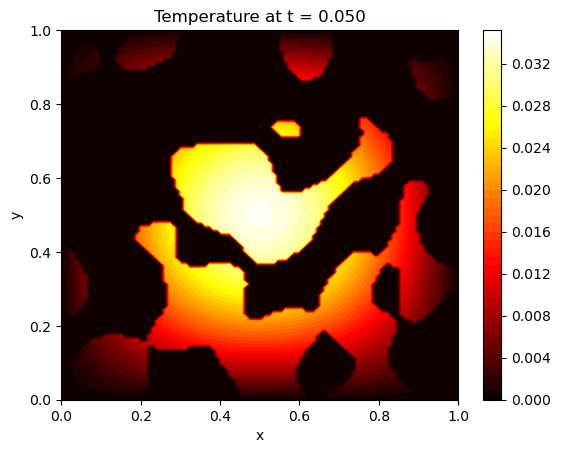

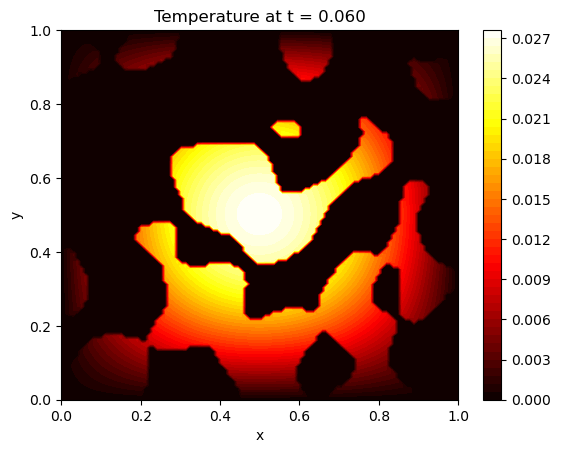

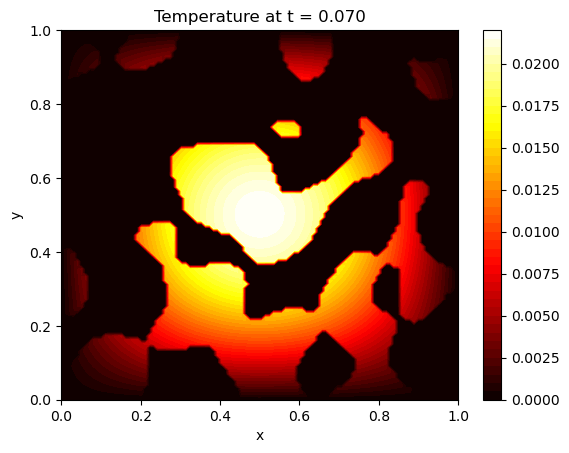

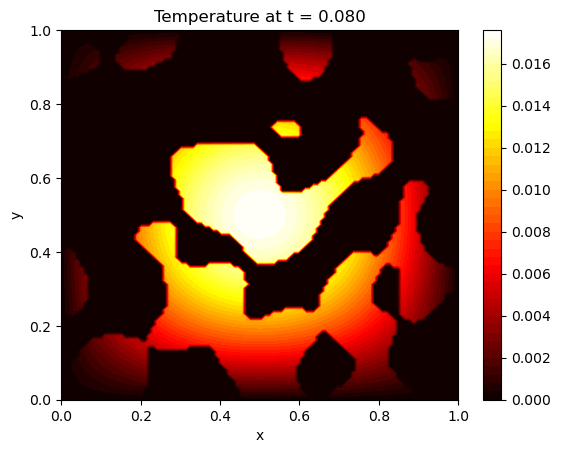

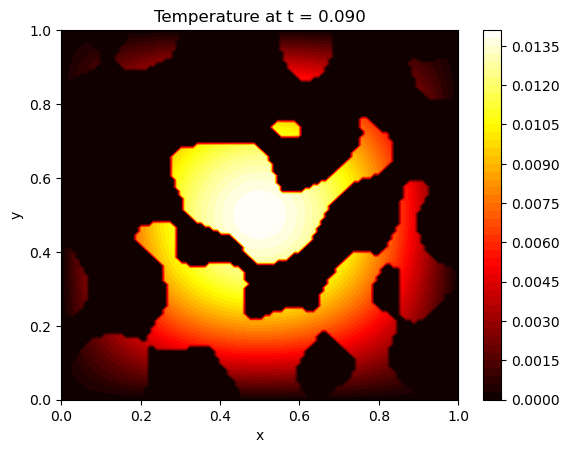

In [21]:
# Define initial condition inside the plate
initial_condition = np.zeros((Ny, Nx))
heat_distribution = np.exp(-((np.linspace(0, Lx, Nx) - Lx / 2)[:, None] ** 2 + (np.linspace(0, Ly, Ny) - Ly / 2)[None, :] ** 2) / 0.01)
initial_condition[mask] = heat_distribution[mask]

# Solve the heat equation
x, y, u = heat_equation_2D_fourier_irregular(Lx, Ly, Nx, Ny, Tmax, Nt, initial_condition, mask)

# Visualize the result
X, Y = np.meshgrid(x, y)
for k in range(0, Nt, Nt // 10):
    print(k)
    plt.figure()
    plt.contourf(X, Y, u[k, :, :], levels=50, cmap="hot")
    plt.colorbar()
    plt.title(f"Temperature at t = {k * Tmax / Nt:.3f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

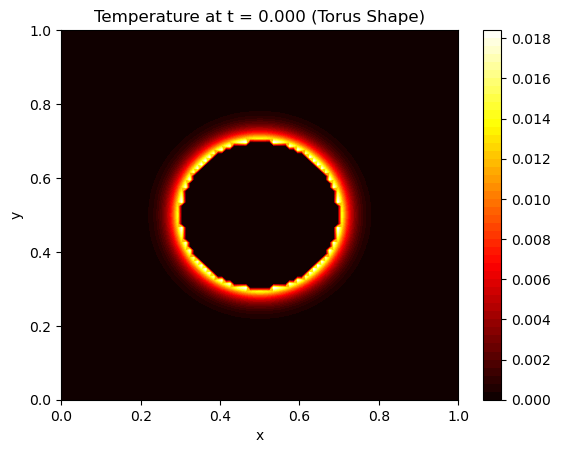

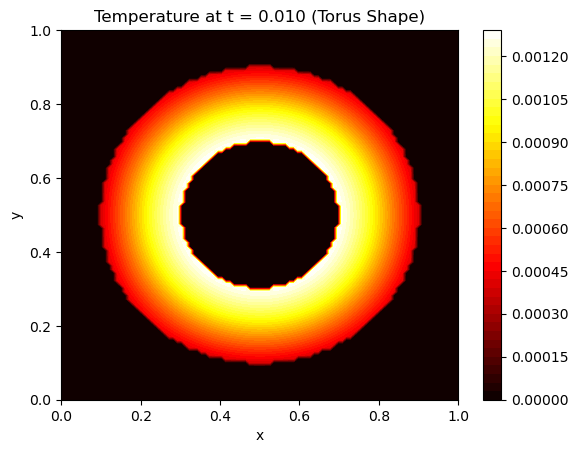

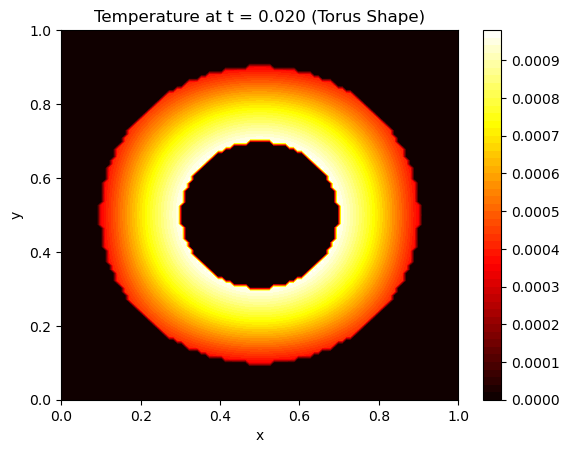

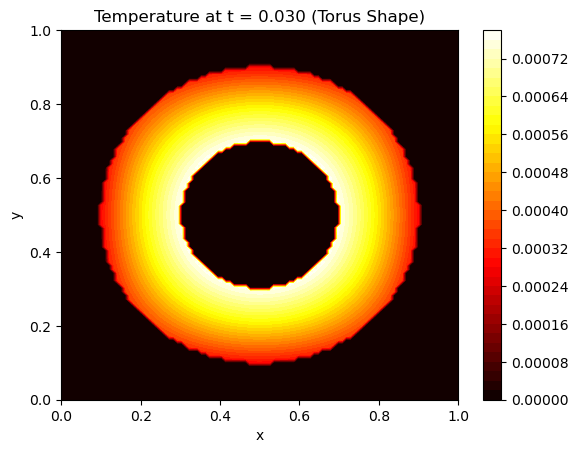

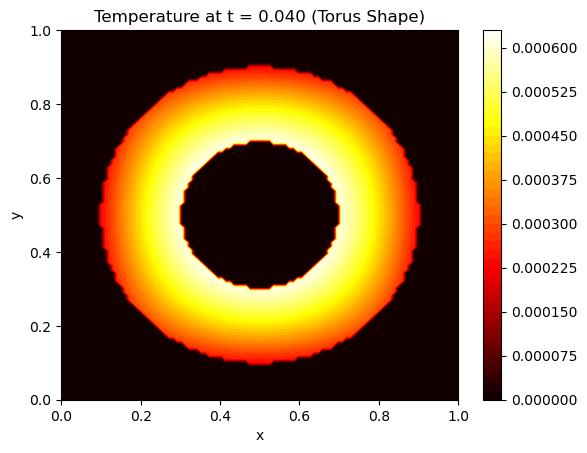

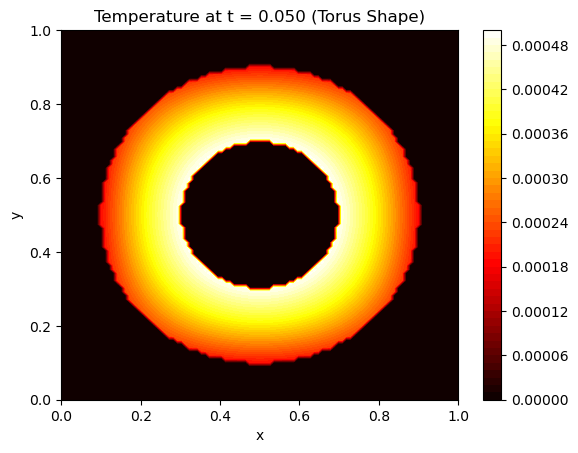

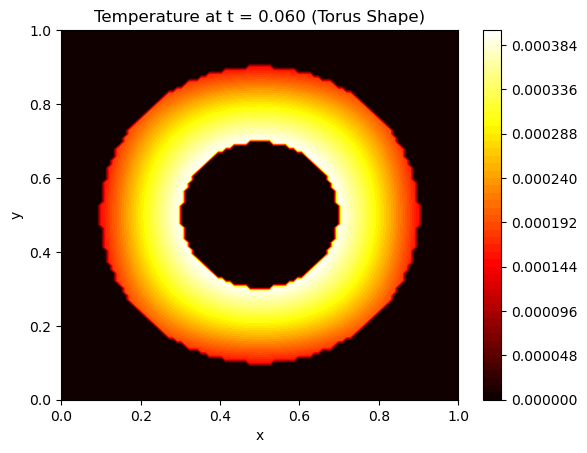

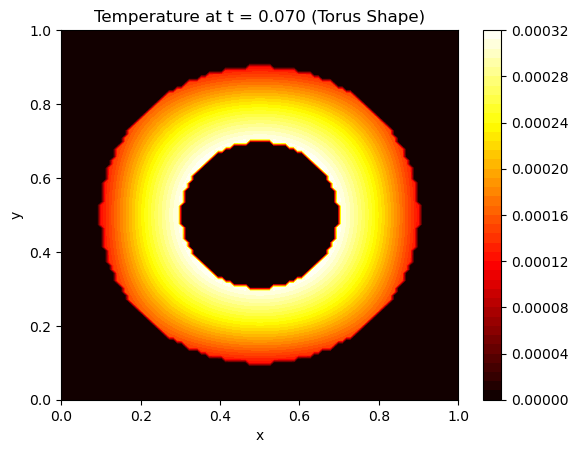

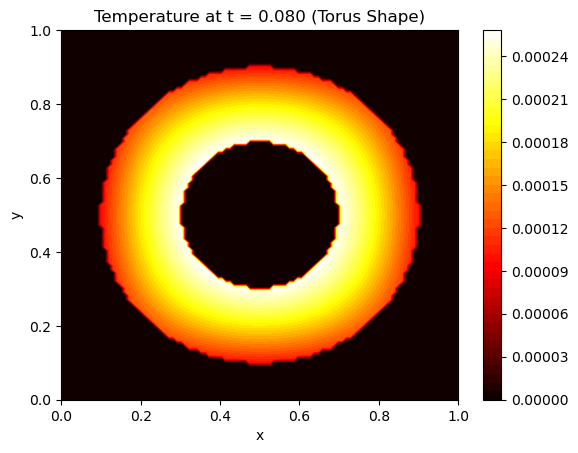

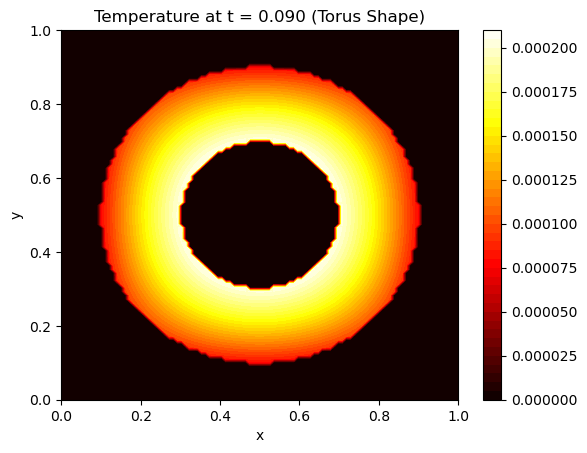

In [22]:
# Parameters for the torus
r_inner = 0.2  # Inner radius
r_outer = 0.4  # Outer radius
center = (0.5, 0.5)  # Center of the torus

# Create the torus mask
def generate_torus_mask(Nx, Ny, Lx, Ly, center, r_inner, r_outer):
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = (distance >= r_inner) & (distance <= r_outer)
    return mask

mask = generate_torus_mask(Nx, Ny, Lx, Ly, center, r_inner, r_outer)

# Define initial condition inside the torus
heat_distribution = np.exp(-((np.linspace(0, Lx, Nx) - center[0])[:, None]**2 + 
                             (np.linspace(0, Ly, Ny) - center[1])[None, :]**2) / 0.01)
initial_condition = np.zeros((Ny, Nx))
initial_condition[mask] = heat_distribution[mask]

# Solve the heat equation
x, y, u = heat_equation_2D_fourier_irregular(Lx, Ly, Nx, Ny, Tmax, Nt, initial_condition, mask)

# Visualize the result
X, Y = np.meshgrid(x, y)
for k in range(0, Nt, Nt // 10):
    plt.figure()
    plt.contourf(X, Y, u[k, :, :], levels=50, cmap="hot")
    plt.colorbar()
    plt.title(f"Temperature at t = {k * Tmax / Nt:.3f} (Torus Shape)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


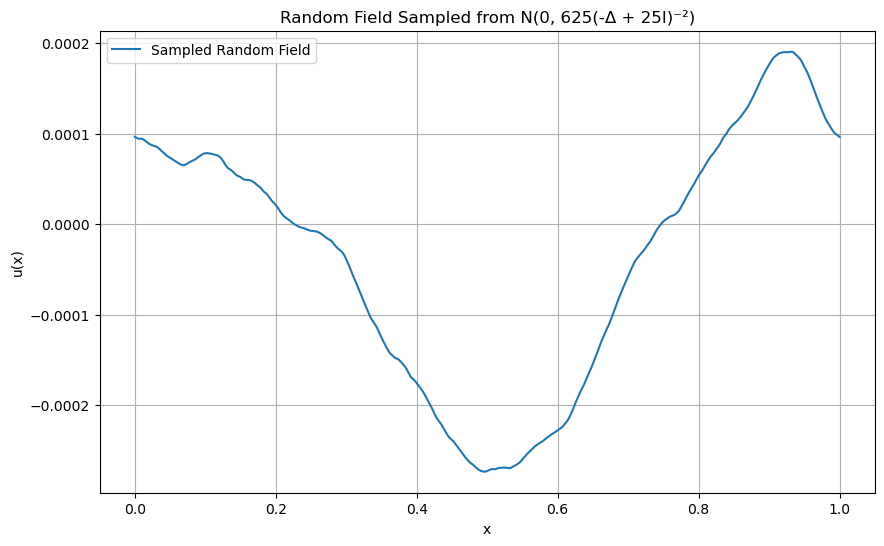

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_field(N, L, scale=625, shift=25):
    """
    Generate a random field sampled from N(0, scale * (-Delta + shift*I)^-2) on a periodic domain.

    Parameters:
        N (int): Number of grid points (spatial resolution).
        L (float): Domain length.
        scale (float): Scaling factor for the covariance operator (default 625).
        shift (float): Shift parameter in the operator (default 25).

    Returns:
        x (ndarray): Spatial grid points.
        field (ndarray): Sampled random field.
    """
    # Define the spatial grid
    x = np.linspace(0, L, N, endpoint=False)  # Periodic grid
    k = np.fft.fftfreq(N, d=L/N) * 2 * np.pi  # Wavenumbers

    # Compute the eigenvalues of the operator (-Delta + shift*I)^-2
    eigenvalues = scale / (k**2 + shift)**2

    # Sample from the Fourier coefficients
    random_coeffs = (np.random.normal(0, np.sqrt(eigenvalues)) +
                     1j * np.random.normal(0, np.sqrt(eigenvalues)))

    # Ensure reality of the field (complex conjugate symmetry)
    random_coeffs[int(N/2)+1:] = np.conj(random_coeffs[1:int(N/2)][::-1])

    # Transform back to physical space
    field = np.fft.ifft(random_coeffs).real

    return x, field

# Parameters
N = 8192  # Number of grid points (resolution)
L = 1.0   # Domain length

# Generate the random field
x, field = generate_random_field(N, L)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(x, field, label="Sampled Random Field")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Random Field Sampled from N(0, 625(-Δ + 25I)⁻²)")
plt.legend()
plt.grid(True)
plt.show()


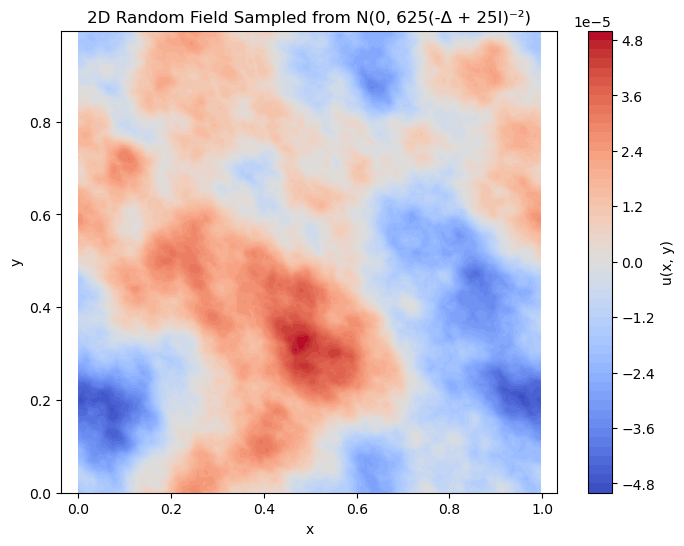

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_field_2D(Nx, Ny, Lx, Ly, scale=625, shift=25):
    """
    Generate a 2D random field sampled from N(0, scale * (-Delta + shift*I)^-2) on a periodic domain.

    Parameters:
        Nx, Ny (int): Number of grid points in x and y directions.
        Lx, Ly (float): Domain lengths in x and y directions.
        scale (float): Scaling factor for the covariance operator (default 625).
        shift (float): Shift parameter in the operator (default 25).

    Returns:
        x (ndarray): x-coordinates of the grid points.
        y (ndarray): y-coordinates of the grid points.
        field (ndarray): Sampled 2D random field.
    """
    # Define spatial grid
    x = np.linspace(0, Lx, Nx, endpoint=False)
    y = np.linspace(0, Ly, Ny, endpoint=False)
    kx = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")  # Wavenumber grid

    # Compute eigenvalues of the covariance operator
    eigenvalues = scale / ((KX**2 + KY**2) + shift)**2

    # Sample from Fourier coefficients
    random_coeffs = (np.random.normal(0, np.sqrt(eigenvalues)) +
                     1j * np.random.normal(0, np.sqrt(eigenvalues)))

    # Ensure reality of the field (complex conjugate symmetry)
    random_coeffs[Nx//2+1:, Ny//2+1:] = np.conj(random_coeffs[1:Nx//2, 1:Ny//2][::-1, ::-1])

    # Transform back to physical space
    field = np.fft.ifft2(random_coeffs).real

    return x, y, field

# Parameters
Nx, Ny = 256, 256  # Number of grid points in x and y directions
Lx, Ly = 1.0, 1.0  # Domain lengths in x and y directions

# Generate the 2D random field
x, y, field = generate_random_field_2D(Nx, Ny, Lx, Ly)

# Plot the result
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, field, levels=50, cmap="coolwarm")
plt.colorbar(label="u(x, y)")
plt.title("2D Random Field Sampled from N(0, 625(-Δ + 25I)⁻²)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


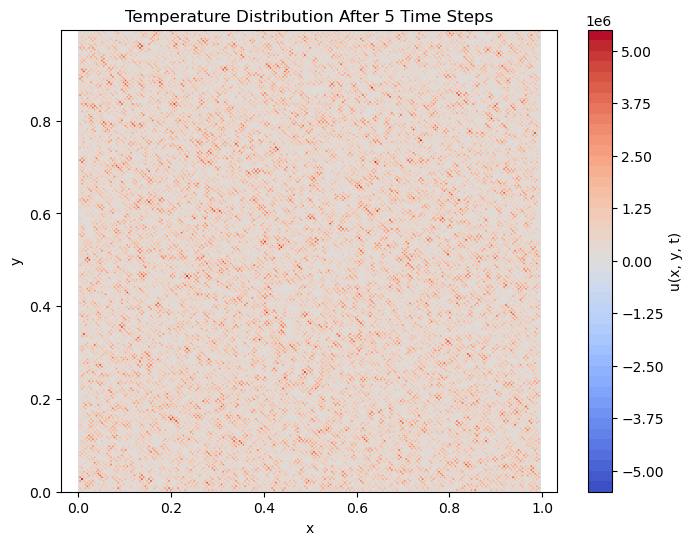

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def solve_heat_equation_2D(field, Nx, Ny, Lx, Ly, kappa=1.0, dt=0.01, num_steps=100):
    """
    Solve the heat equation in 2D using finite difference method.

    Parameters:
        field (ndarray): Initial temperature distribution.
        Nx, Ny (int): Number of grid points in x and y directions.
        Lx, Ly (float): Domain lengths in x and y directions.
        kappa (float): Thermal diffusivity constant.
        dt (float): Time step size.
        num_steps (int): Number of time steps.

    Returns:
        u (ndarray): Final temperature distribution after solving the heat equation.
        history (list): History of the temperature distribution over time.
    """
    # Define the grid spacing
    dx = Lx / Nx
    dy = Ly / Ny

    # Create an array to store the temperature distribution at each time step
    u = field.copy()
    history = [u]

    # Iterate over time steps
    for _ in range(num_steps):
        u_new = u.copy()
        
        # Update the temperature at each grid point using the finite difference method
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                # Apply the finite difference formula for the Laplacian
                laplacian = (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4 * u[i, j]) / (dx * dy)
                u_new[i, j] = u[i, j] + dt * kappa * laplacian
        
        u = u_new
        history.append(u)
    
    return u, history

# Parameters for the heat equation solver
kappa = 1.0  # Thermal diffusivity constant
dt = 0.001  # Time step size
num_steps = 5 # Number of time steps

# Solve the heat equation
final_field, history = solve_heat_equation_2D(field, Nx, Ny, Lx, Ly, kappa, dt, num_steps)

# Plot the final temperature distribution
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, final_field, levels=50, cmap="coolwarm")
plt.colorbar(label="u(x, y, t)")
plt.title(f"Temperature Distribution After {num_steps} Time Steps")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()
